In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn

from sklearn.decomposition import PCA

from torch.utils.data import DataLoader

import vari
import vari.datasets
import vari.models
import vari.inference

from vari.layers import GaussianLayer, BernoulliLayer
from vari.utilities import compute_dataset_elbo, remove_outliers, get_device
from vari.utilities.plotting import plot_image_matrix
from vari.utilities.checkpoint import load_models

from sklearn.datasets import make_circles

In [3]:
experiments_dir = vari.settings.EXPERIMENTS_DIR
data_root = '/home/jdh/repos/vari/torch_data'
output_dir = f'{os.getcwd()}/plots'
plot_ext = '.svg'
mpl.style.use('default')
device = get_device()
print(device)

cuda:0


In [4]:
def get_constant_colormap(rgb_color):
    # Colormap that is constant at the given rgb_color.
    r, g, b = rgb_color
    cdict = {'red': [(0, r, r), (1, r, r)], 
             'green': [(0, g, g), (1, g, g)],
             'blue': [(0, b, b), (1, b, b)]}
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

## Select models and data

In [30]:
run_ids_mnist = {
    '[64]': 7874,
    '[64,32,16]': 7788,
}

run_ids_fashion_mnist = {
    '[64] small': 7783,
    '[64]': 7875,
#     '[64,32]': 7784,
    '[64,32,16]': 7787,
#     '[32,16,2,2]': 7873,
}

## Load models

In [31]:
print('MNIST')
models_mnist = load_models(run_ids_mnist, device=device)
print('FashionMNIST')
models_fashion_mnist = load_models(run_ids_fashion_mnist, device=device)

MNIST
FashionMNIST


## Get data

In [7]:
mnist_train = vari.datasets.MNISTContinuous(split='train', preprocess='static', exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTContinuous(split='test', preprocess='static', exclude_labels=[], root=data_root)
fashion_mnist_train = vari.datasets.FashionMNISTContinuous(split='train', preprocess='static', exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTContinuous(split='test', preprocess='static', exclude_labels=[], root=data_root)

### Visualize dataset

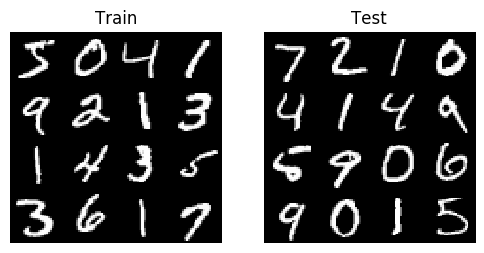

In [8]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');
fig.savefig(output_dir + f'/Dataset_MNIST' + plot_ext, bbox_inches='tight')

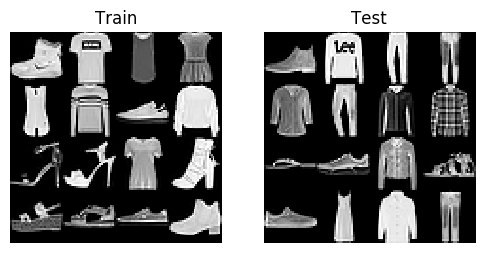

In [9]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(fashion_mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(fashion_mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');
fig.savefig(output_dir + f'/Dataset_FashionMNIST' + plot_ext, bbox_inches='tight')

### Log Bernoulli distance between datasets

In [10]:
mnist_train_real = vari.datasets.MNISTContinuous(split='train', preprocess='deterministic',
                                                 exclude_labels=[], root=data_root)
mnist_test1_real = vari.datasets.MNISTContinuous(split='test', preprocess='deterministic',
                                                 exclude_labels=[], root=data_root)

In [11]:
fashion_mnist_train_real = vari.datasets.FashionMNISTContinuous(split='train', preprocess='deterministic',
                                                                exclude_labels=[], root=data_root)
fashion_mnist_test1_real = vari.datasets.FashionMNISTContinuous(split='test', preprocess='deterministic',
                                                                exclude_labels=[], root=data_root)

In [12]:
# Mean pixel activation
mnist_train_real.examples.mean(), fashion_mnist_train_real.examples.mean()

(0.13066062, 0.2860402)

In [13]:
# Average number of pixels activated above 0.5
(mnist_train_real.examples>0.5).sum(axis=(-1,-2)).mean(), \
(fashion_mnist_train_real.examples>0.5).sum(axis=(-1,-2)).mean()

(103.69051666666667, 246.69171666666668)

In [14]:
def log_bernoulli(x, p, eps=1e-8):
    return np.log(p + eps) * x + np.log(1 - p + eps) * (1 - x)

In [15]:
def nearest_neighbour_distance_bernoulli(x, p, ignore_diag):
    x = x[np.newaxis, ...]
    p = p[:, np.newaxis, ...]
    d = np.sum(log_bernoulli(x, p), axis=-1)
    if ignore_diag:
        np.fill_diagonal(d, val=np.nan)
    return np.nanmax(d, axis=-1)

In [16]:
n_samples = 1000
train = mnist_train_real.examples[:n_samples].reshape(-1, 784)
test1 = fashion_mnist_train_real.examples[:n_samples].reshape(-1, 784)
nnd_train_mnist = nearest_neighbour_distance_bernoulli(x=train, p=train, ignore_diag=True)
nnd_test1_mnist = nearest_neighbour_distance_bernoulli(x=test1, p=train, ignore_diag=False)

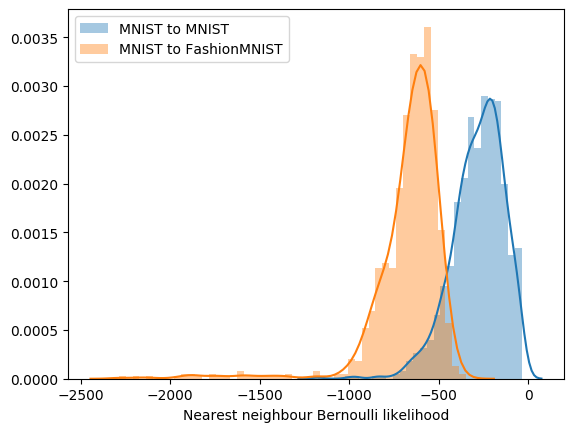

In [17]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train_mnist, ax=ax, label='MNIST to MNIST')
seaborn.distplot(nnd_test1_mnist, ax=ax, label='MNIST to FashionMNIST')
ax.set_xlabel('Nearest neighbour Bernoulli likelihood')
ax.legend()
fig.savefig(output_dir + '/DataDistance_MNIST-FashionMNIST' + plot_ext, bbox_inches='tight')

In [18]:
n_samples = 1000
train = fashion_mnist_train_real.examples[:n_samples].reshape(-1, 784)
test1 = mnist_train_real.examples[:n_samples].reshape(-1, 784)
nnd_train_fashion = nearest_neighbour_distance_bernoulli(x=train, p=train, ignore_diag=True)
nnd_test1_fashion = nearest_neighbour_distance_bernoulli(x=test1, p=train, ignore_diag=False)

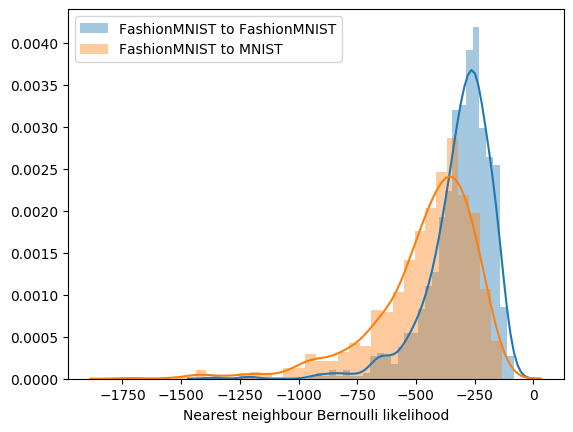

In [19]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train_fashion, ax=ax, label='FashionMNIST to FashionMNIST')
seaborn.distplot(nnd_test1_fashion, ax=ax, label='FashionMNIST to MNIST')
ax.set_xlabel('Nearest neighbour Bernoulli likelihood')
ax.legend()
fig.savefig(output_dir + '/DataDistance_FashionMNIST-MNIST' + plot_ext, bbox_inches='tight')

In the above we compute the summed Bernoulli likelihood of image $I$ from FashionMNIST when the pixels of image $J$ from MNIST is used as the true probabilities for all $I$ and $J$ (really a subsample). We choose the largest of these likelihoods for each of the $J$ images and plot the distribution. We also compute this for MNIST under MNIST. Finally, we repeat this for MNIST VS FashionMNIST.

We see that the distance to MNIST under FashionMNIST pixel probabilities is smaller than the difference to FashionMNIST under MNIST pixel probabilities. 

That is, MNIST is "contained within" FashionMNIST. This is to be understood as MNIST activating fewer pixels and activating them less on average than FashionMNIST does.

Nalisnick claims to be able to detect FashionMNIST as OOD when training on MNIST. Also, MNIST has higher likelihoods than FashionMNIST when training on FashionMNIST. This is the same assymmetry as observed in the plots above.

However, from the plots above it is clear that MNIST is not "enough within" FashionMNIST to cause MNIST to be more likely than FashionMNIST itself when evaluated under FashionMNIST pixel probabilities. This serves to show that the only way to ascribe MNIST higher likelihood than FashionMNIST when training on FashionMNIST is due to poor modelling.

## Visualize latent space

In [10]:
def encode_latents(model, data, do_pca=True):
    torch.manual_seed(1)
    with torch.no_grad():
        latents = model.encode(data.view(-1, *model.in_shape))

    samples = dict()
    mean = dict()
    for i, name in enumerate(latents.keys(), start=1):
        qz = latents[name][0].squeeze().cpu().numpy()
        qz_mu = latents[name][1].mean.squeeze().cpu().numpy()

        # PCA if more than 2D
        if do_pca and qz.shape[-1] > 2:
            pca = PCA(n_components=2, random_state=0)
            qz = pca.fit_transform(qz)
            qz_mu = pca.transform(qz_mu)

        samples[name] = qz
        mean[name] = qz_mu
    return samples, mean

In [11]:
def plot_latents(latents, class_labels=None, **kwargs):
    cmap = kwargs.get('cmap', None)
    latents_kde = kwargs.get('latents_kde', latents)

    n_cols = len(qz_train.keys())
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    if n_cols == 1:
        axes = [axes]
    
    for i, name in enumerate(latents.keys(), start=1):
        axes[i - 1].set_title(f'$q(z_{i}|x), x\sim p_{{train}}(x)$')
        if class_labels is not None:
            for c in set(class_labels):
                axes[i - 1].scatter(latents[name][class_labels==c, 0],
                                    latents[name][class_labels==c, 1],
                                    marker='o', s=2, alpha=0.8, color=f'C{c}', label=f'$z_{i}$ class {c}')
        else:
            axes[i - 1].scatter(latents[name][:, 0],
                                latents[name][:, 1],
                                marker='o', s=2, alpha=0.8, label=f'$z_{i}$')

        seaborn.kdeplot(latents_kde[name][:, 0],
                        latents_kde[name][:, 1],
                        shade=False, cmap=cmap, label=f'$q(z_{i}|x)$', ax=axes[i - 1])
    return fig, axes

In [12]:
constant_cmap = get_constant_colormap([0,0,0])

In [13]:
torch.cuda.empty_cache()

### MNIST

In [14]:
n_samples = 4000

x_train = mnist_train.examples[:n_samples]
x_test = mnist_test1.examples[:n_samples]
y_train = mnist_train.labels.argmax(axis=1)[:n_samples]
y_test = mnist_test1.labels.argmax(axis=1)[:n_samples]

[64]
[64,32,16]


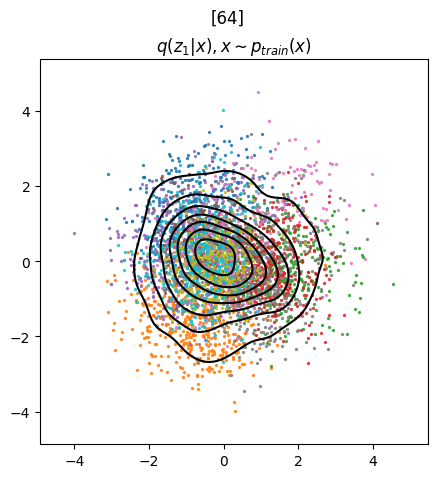

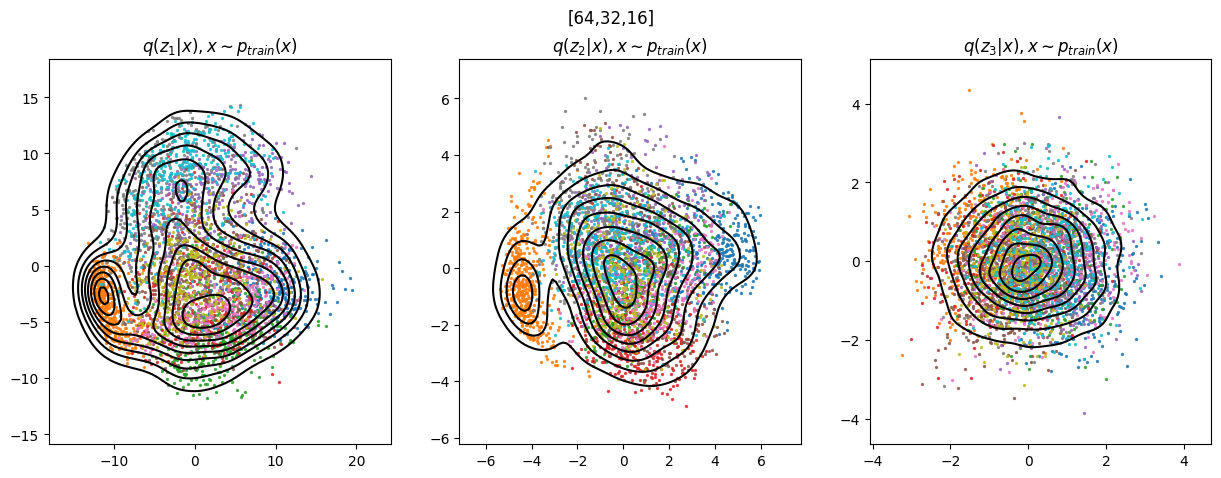

In [15]:
models = models_mnist
ids = run_ids_mnist
dset = 'MNIST'

for abbr, model in models.items():
    print(abbr)
    qz_train, qz_mu_train = encode_latents(model, torch.FloatTensor(x_train).to(device))
    qz_test, qz_mu_test = encode_latents(model, torch.FloatTensor(x_test).to(device))
    
    fig, axes = plot_latents(qz_test, class_labels=y_test, cmap=constant_cmap)
    fig.suptitle(abbr)
    fig.savefig(output_dir + f'/{dset}_LatentSpace_test_ID{ids[abbr]}' + plot_ext, bbox_inches='tight')

### FashionMNIST

In [16]:
n_samples = 4000

x_train = fashion_mnist_train.examples[:n_samples]
x_test = fashion_mnist_test1.examples[:n_samples]
y_train = fashion_mnist_train.labels.argmax(axis=1)[:n_samples]
y_test = fashion_mnist_test1.labels.argmax(axis=1)[:n_samples]

[64]
[64,32]
[64,32,16]
[32,16,2,2]


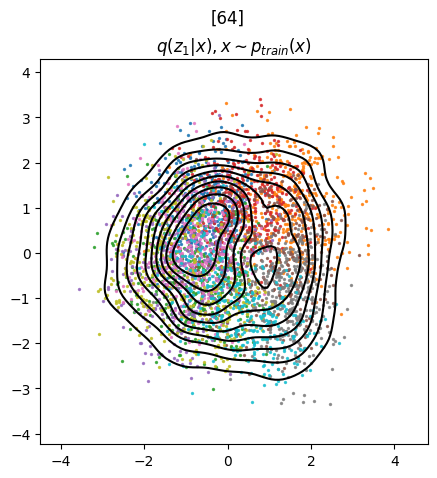

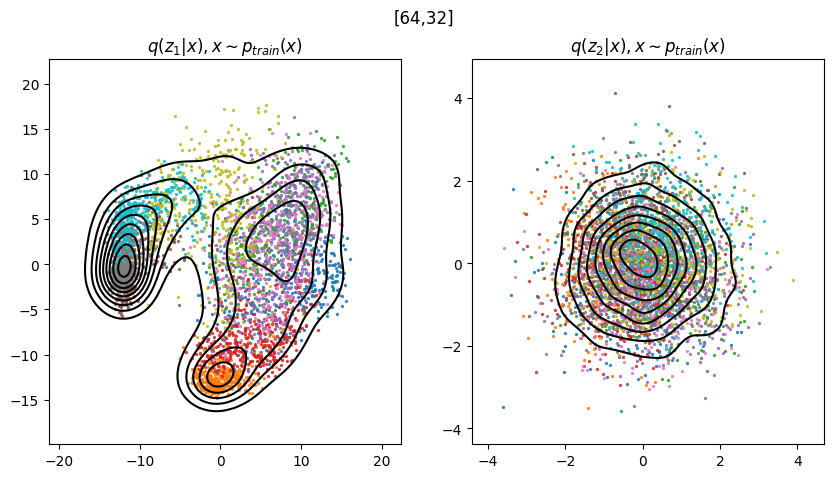

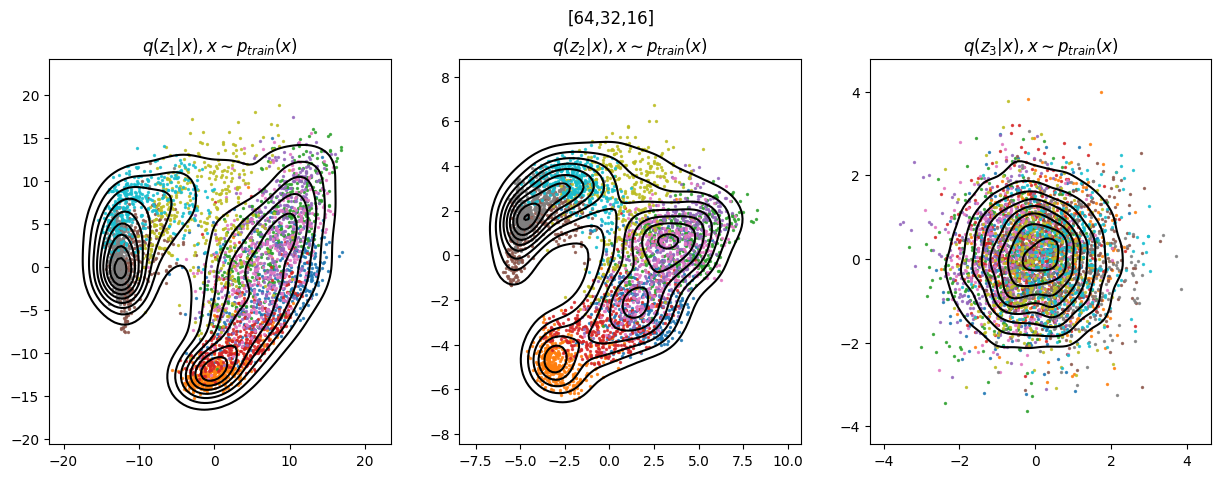

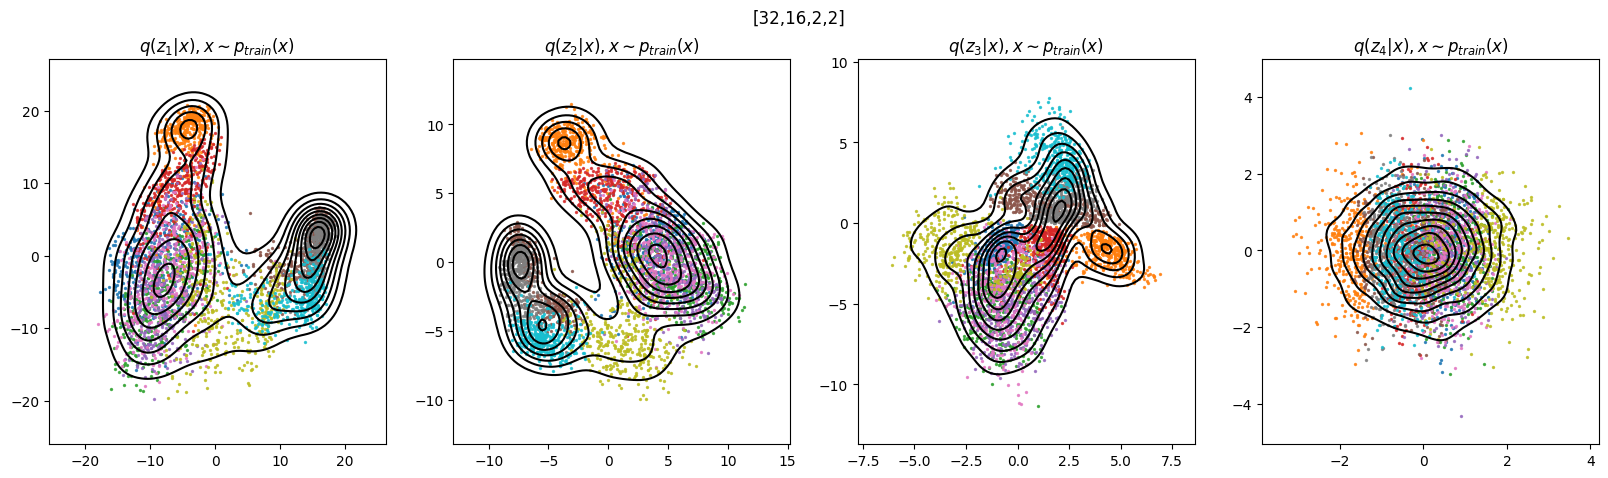

In [17]:
models = models_fashion_mnist
ids = run_ids_fashion_mnist
dset = 'FashionMNIST'

for abbr, model in models.items():
    print(abbr)
    qz_train, qz_mu_train = encode_latents(model, torch.FloatTensor(x_train).to(device))
    qz_test, qz_mu_test = encode_latents(model, torch.FloatTensor(x_test).to(device))
    
    fig, axes = plot_latents(qz_test, class_labels=y_test, cmap=constant_cmap)
    fig.suptitle(abbr)
    fig.savefig(output_dir + f'/{dset}_LatentSpace_test_ID{ids[abbr]}' + plot_ext, bbox_inches='tight')

## Visualize reconstruction and samples
### MNIST models

In [18]:
def get_copy_latents(n_layers, free_latents):
    return dict((f'z{i+1}', True) if i >= free_latents else (f'z{i+1}', False) for i in range(n_layers))

In [19]:
def plot_sample_reconstruct(model, data, free_latents=False):
    x_in = torch.FloatTensor(data)
    
    with torch.no_grad():
        px_samples = model.generate(n_samples)

    n_cols = 3 + free_latents * (model.n_layers - 1)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    plot_image_matrix([x.view(*mnist_test1[0][0].shape) for x in x_in], axes[0])
    plot_image_matrix([x.view(*mnist_test1[0][0].shape) for x in px_samples.mean.cpu()], axes[-1])
    with torch.no_grad():
        if free_latents:
            for free_latents in range(model.n_layers):
                copy_latents = get_copy_latents(model.n_layers, free_latents)
                px_reconstructions = model(x_in.reshape(x_in.shape[0], *model.in_shape).to(device),
                                           copy_latents=copy_latents)
                plot_image_matrix([x.reshape(*mnist_test1[0][0].shape) for x in px_reconstructions.mean.cpu()],
                                  axes[free_latents+1])
                axes[free_latents+1].set_title(f'Rec. ({free_latents} free)')
        else:
            px_reconstructions = model(x_in.view(x_in.shape[0], *model.in_shape).to(device))
            plot_image_matrix([x.view(*svhn_test1[0][0].shape) for x in px_reconstructions.mean.cpu()], axes[1])
            axes[1].set_title('Reconstructions')

    axes[0].set_title('Originals')
    axes[-1].set_title('Samples')
    return fig, axes

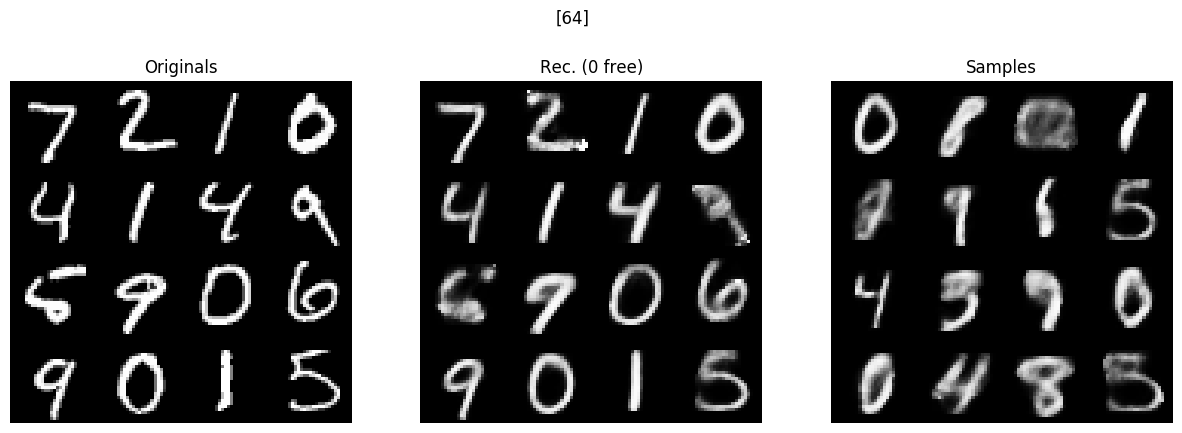

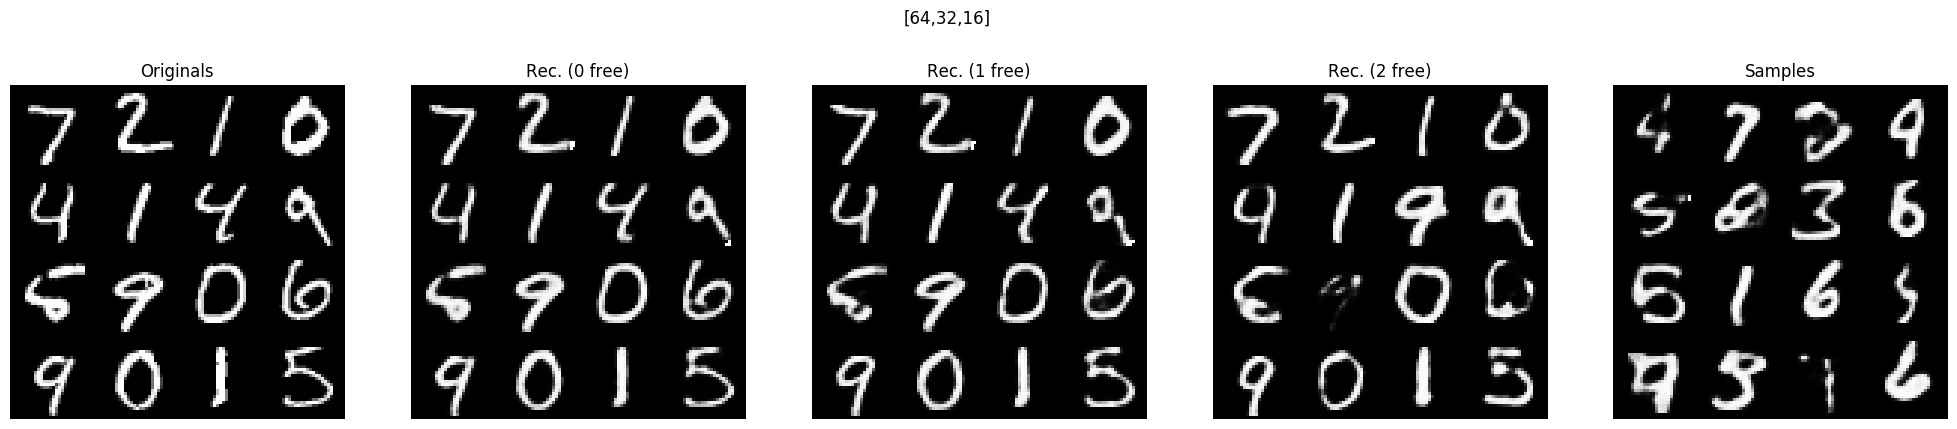

In [20]:
models = models_mnist
ids = run_ids_mnist
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, mnist_test1[:n_samples][0], free_latents=True)
    fig_name = f'{ids[abbr]}'
    fig.suptitle(abbr)
    fig.savefig(output_dir + f'/MNIST_SampleReconstruct_MNIST_ID{fig_name}' + plot_ext, bbox_inches='tight')

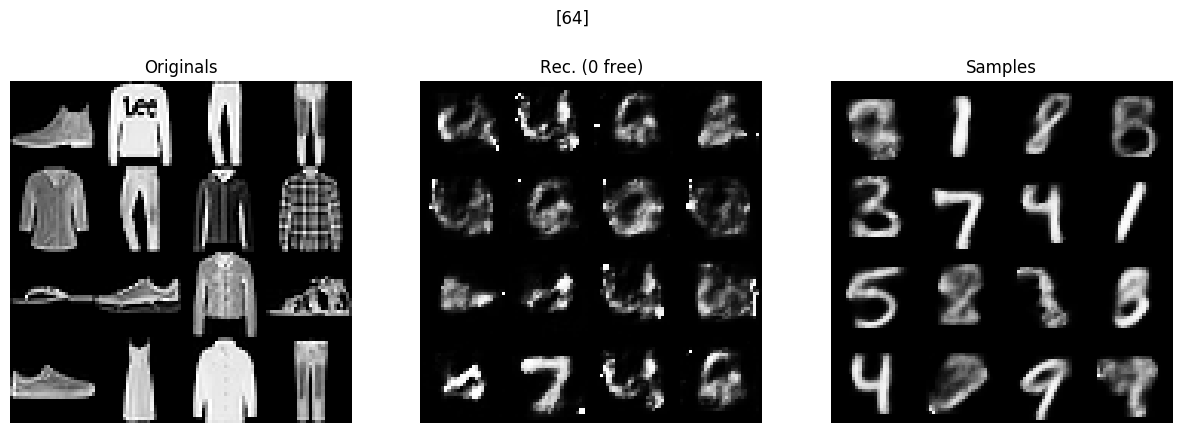

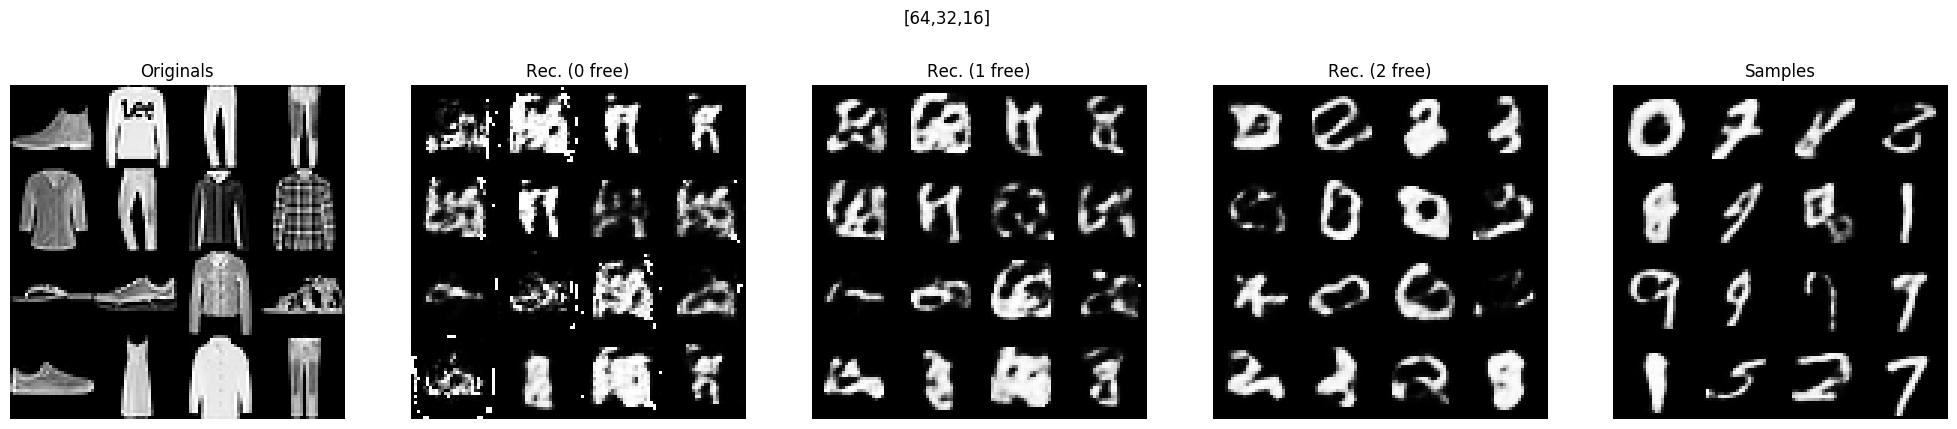

In [21]:
models = models_mnist
ids = run_ids_mnist
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, fashion_mnist_test1[:n_samples][0], free_latents=True)
    fig_name = f'{ids[abbr]}'
    fig.suptitle(abbr)
    fig.savefig(output_dir + f'/MNIST_SampleReconstruct_FashionMNIST_ID{fig_name}' + plot_ext, bbox_inches='tight')

The more complex the dataset, the more abstract and diverse the set of features that the model needs to learn becomes.

Models that are trained on complex datasets and succesfully learn such a diverse set of abstract features may show surprisingly good performance on reconstructing simpler datasets that share some fundamental features.

**Observation**
The smaller models have a harder time reconstructing out of domain data. Multilayered models perform better at this. However, when not copying all latents in the hierarchy, the multilayered models regain their superiority over single-layered models and nicely collapse the out-of-distribution inputs into the mode of the training set.

**Hypothesis**
If we use convolutional models this trend will be even more pronounced since features are learned invariant to position within the image.

### FashionMNIST models

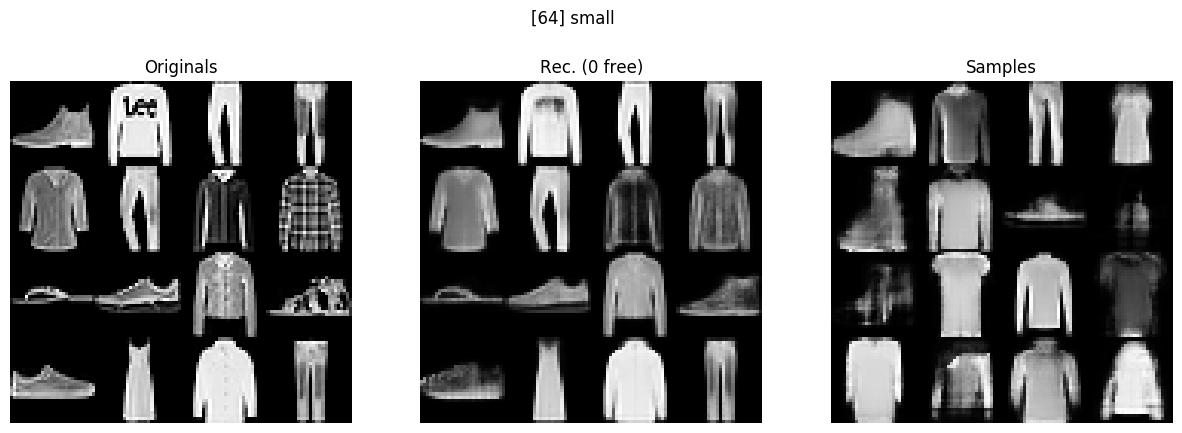

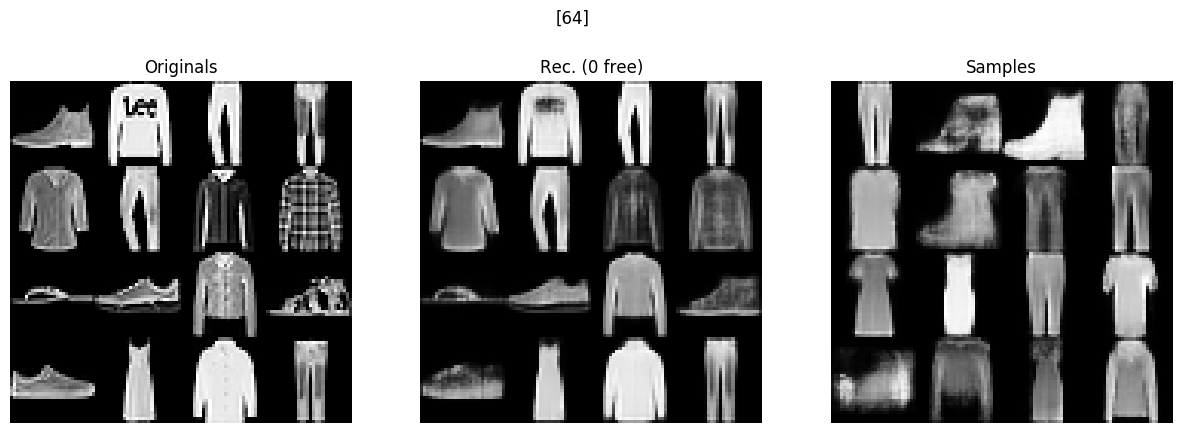

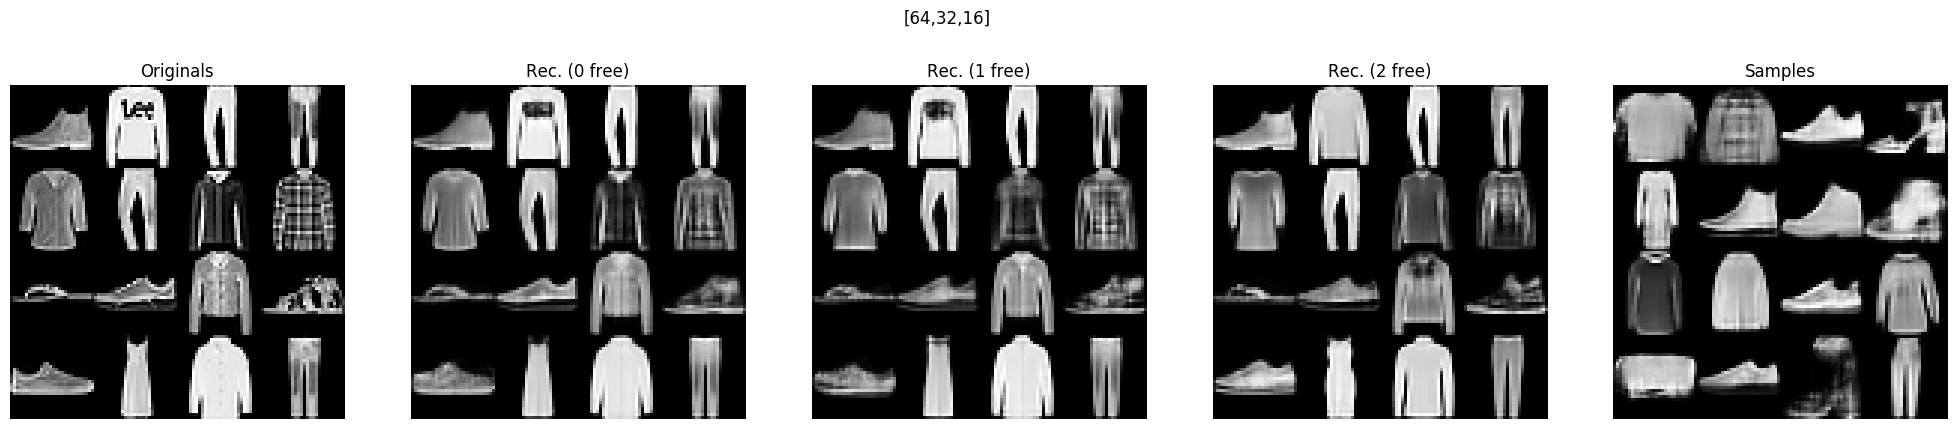

In [32]:
models = models_fashion_mnist
ids = run_ids_fashion_mnist
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, fashion_mnist_test1[:n_samples][0], free_latents=True)
    fig_name = f'{ids[abbr]}'
    fig.suptitle(abbr)
    fig.savefig(output_dir + f'/FashionMNIST_SampleReconstruct_FashionMNIST_ID{fig_name}' + plot_ext, bbox_inches='tight')

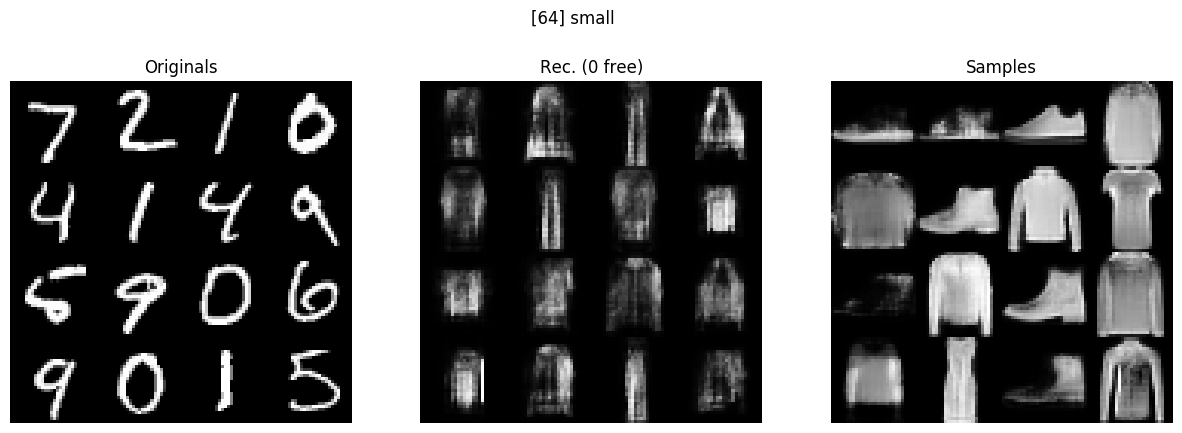

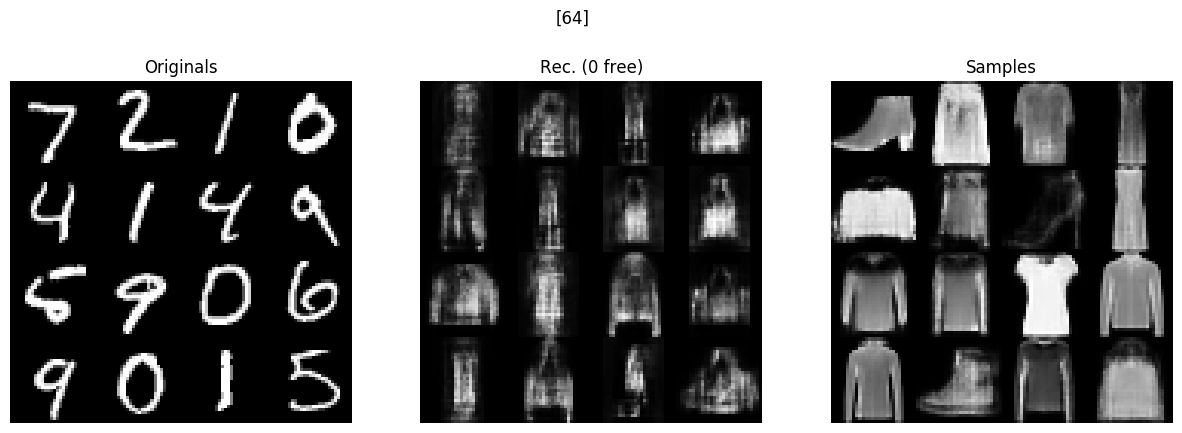

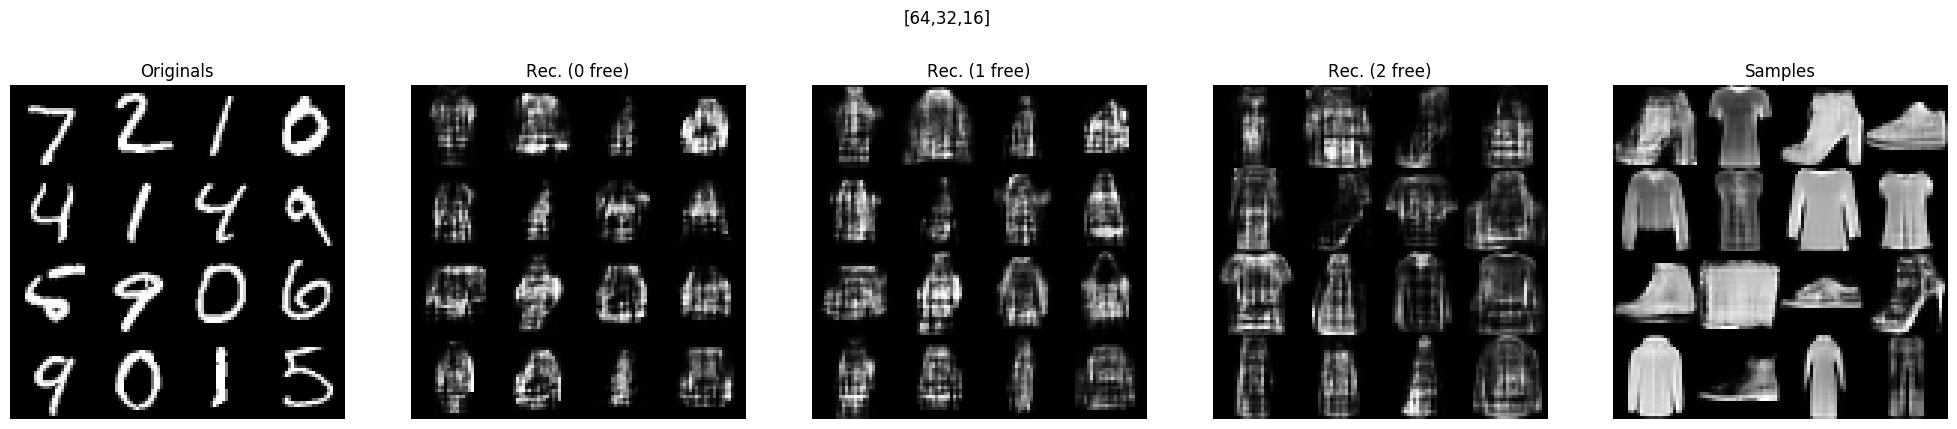

In [33]:
models = models_fashion_mnist
ids = run_ids_fashion_mnist
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, mnist_test1[:n_samples][0], free_latents=True)
    fig_name = f'{ids[abbr]}'
    fig.suptitle(abbr)
    fig.savefig(output_dir + f'/FashionMNIST_SampleReconstruct_MNIST_ID{fig_name}' + plot_ext, bbox_inches='tight')

## OOD detection based on ELBO

In [24]:
def log_transform(x):
     return np.sign(x) * np.log(np.abs(x))

def log_transform_2(x, C=0):
    return np.sign(x) * np.log(1 + np.abs(x) / 10 ** C)

In [25]:
def plot_ood(model, loaders, free_latents=0, importance_samples=1, log_prob_transform=None):
    copy_latents = get_copy_latents(model.n_layers, free_latents)

    if log_prob_transform is None:
        log_prob_transform = lambda x: x
    
    n_cols = int(model.n_layers > 1) + 3
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    
    with torch.no_grad():
        for i_loader, (name, loader) in enumerate(loaders.items()):
            torch.manual_seed(0)

            elbo, likelihood, kl, kls = compute_dataset_elbo(model, loader, device=device,
                                                             copy_latents=copy_latents,
                                                             reduce_importance_samples=False,
                                                             importance_samples=importance_samples)
            
            elbo = torch.mean(elbo.view(importance_samples, -1), axis=0).cpu()
            likelihood = torch.mean(likelihood.view(importance_samples, -1), axis=0).cpu()
            kl = torch.mean(kl.view(importance_samples, -1), axis=0).cpu()
            
            (elbo, likelihood, kl), _ = remove_outliers(elbo, likelihood, kl)
            
            seaborn.distplot(log_prob_transform(elbo), kde_kws={}, ax=axes[0], label=name)
            seaborn.distplot(log_prob_transform(likelihood), kde_kws={}, ax=axes[1], label=name)
            seaborn.distplot(log_prob_transform(kl), kde_kws={}, ax=axes[2], label=name)
            
            if model.n_layers > 1:
                for i_latent, (latent_name, value) in enumerate(reversed(kls.items())):
                    value = torch.mean(value.view(importance_samples, -1), axis=0).cpu()
                    value, _ = remove_outliers(value)
                    seaborn.distplot(value, kde_kws={}, ax=axes[3], label=f'{latent_name} {name}',
                                     color=f'C{i_latent * len(loaders) + i_loader}')
    
    labels = (r'$\log p(x)$', r'$\log p(x|z)$', r'$\frac{\log q(z|x)}{\log p(z)}$',
                                                r'$\frac{\log q(z|x)}{\log p(z)}$')
    for i, ax in enumerate(axes):
        ax.legend()
        ax.set_xlabel(labels[i])

    return fig, axes

In [26]:
mnist_train = vari.datasets.MNISTContinuous(split='train', preprocess='dynamic',
                                            exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTContinuous(split='test', preprocess='dynamic',
                                            exclude_labels=[], root=data_root)
fashion_mnist_train = vari.datasets.FashionMNISTContinuous(split='train', preprocess='dynamic',
                                                           exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTContinuous(split='test', preprocess='dynamic',
                                                           exclude_labels=[], root=data_root)

In [27]:
loader_fashion_mnist_test1 = DataLoader(fashion_mnist_test1, batch_size=256, pin_memory=True)
loader_mnist_test1 = DataLoader(mnist_test1, batch_size=256, pin_memory=True)

In [28]:
seaborn.set_palette('tab20')

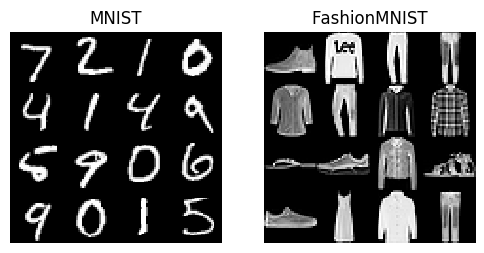

In [29]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix([x for x in next(iter(loader_mnist_test1))[0][:n_images]], ax1)
plot_image_matrix([x for x in next(iter(loader_fashion_mnist_test1))[0][:n_images]], ax2)
ax1.set_title('MNIST')
ax2.set_title('FashionMNIST');

### mnist

0 [64]
0 [64,32,16]
1 [64,32,16]
2 [64,32,16]


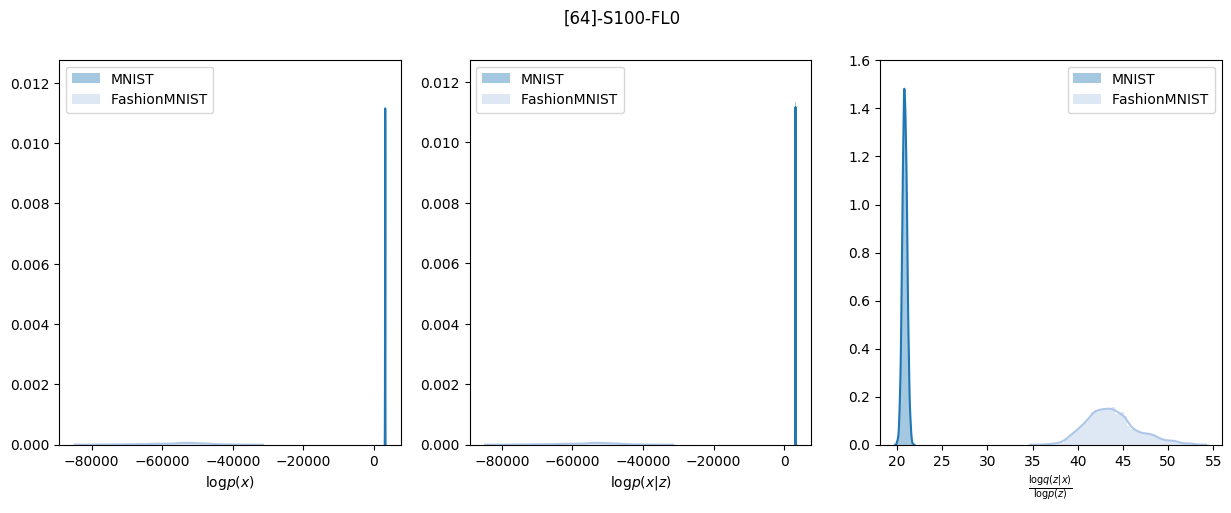

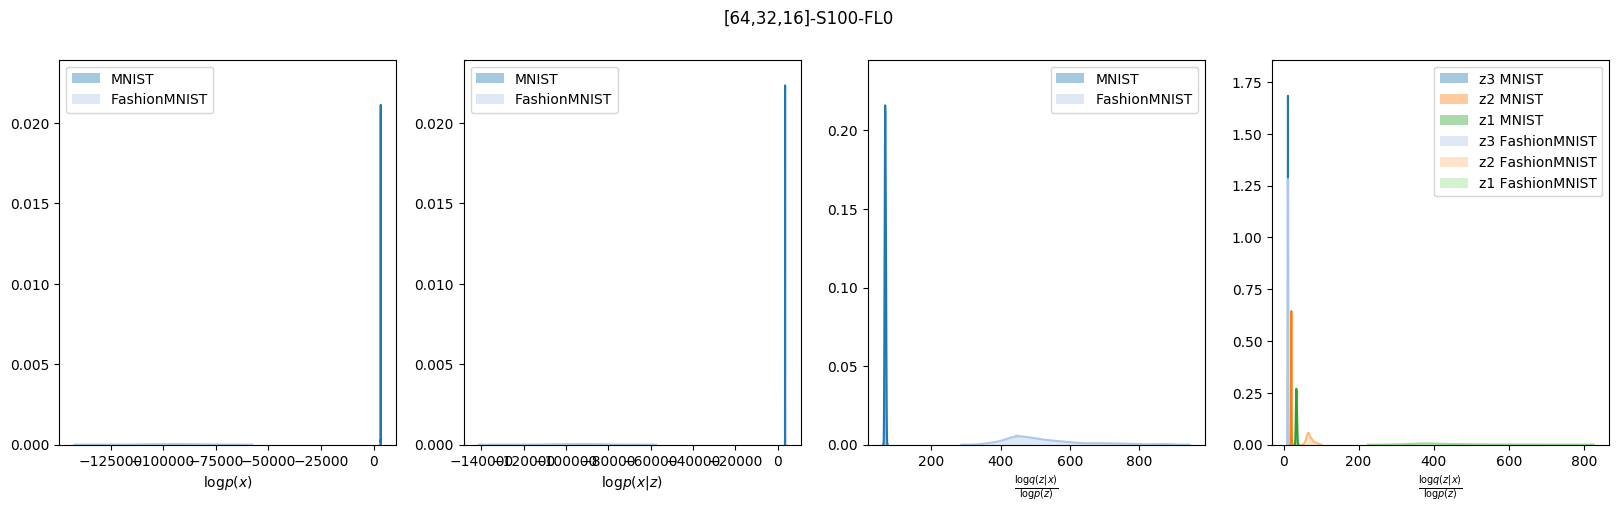

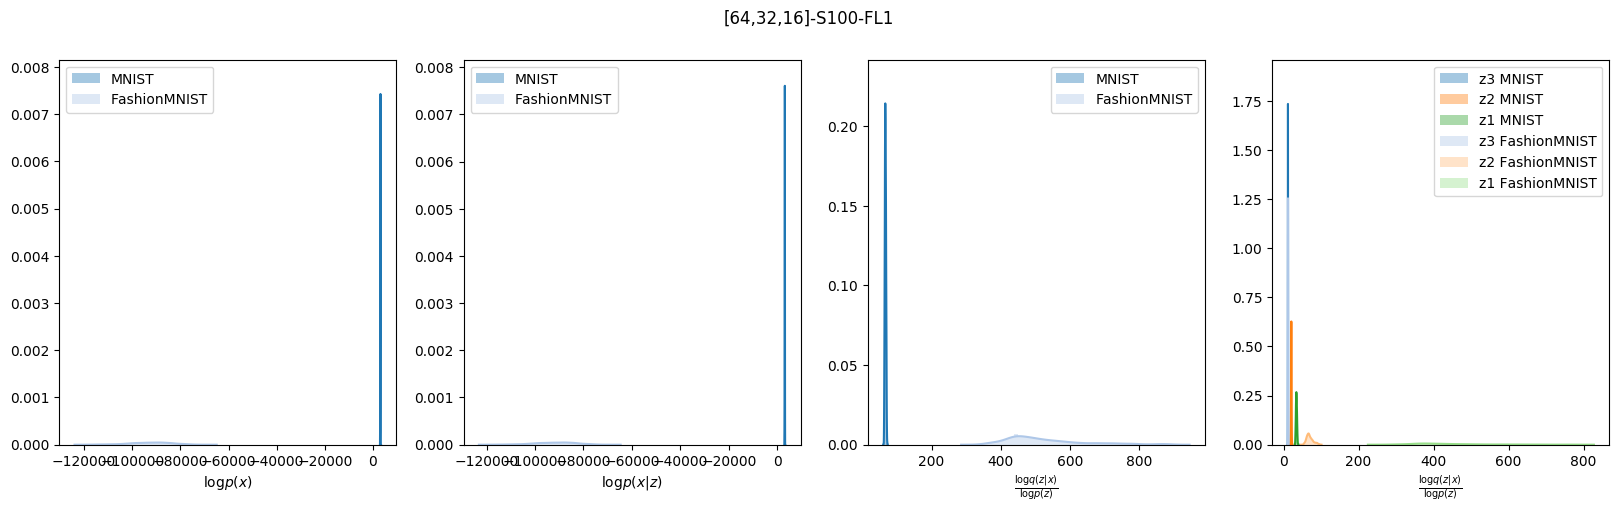

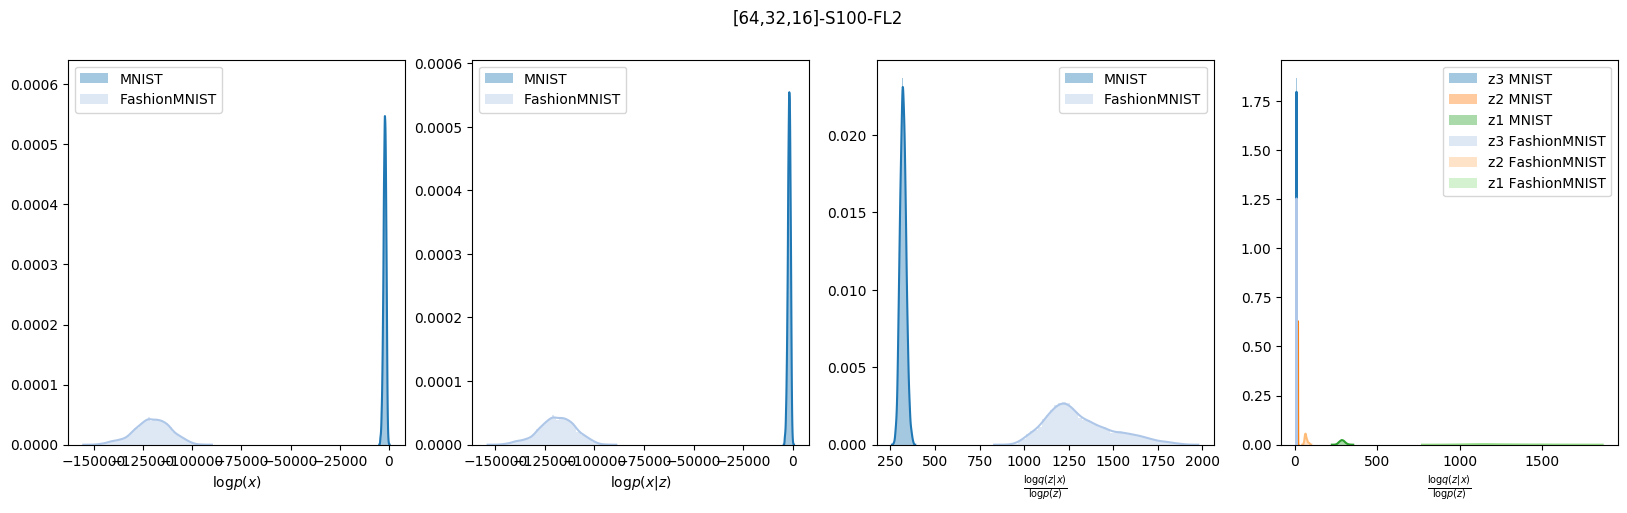

In [95]:
models = models_mnist
ids = run_ids_mnist
loaders_mnist = dict(MNIST=loader_mnist_test1,
                     FashionMNIST=loader_fashion_mnist_test1)
importance_samples = 100

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{ids[abbr]}-S{importance_samples}-FL{free_latents}'
        fig_suptitle = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_mnist, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_suptitle)
        fig.savefig(output_dir + f'/MNIST_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

0 [64]
0 [64,32,16]
1 [64,32,16]
2 [64,32,16]


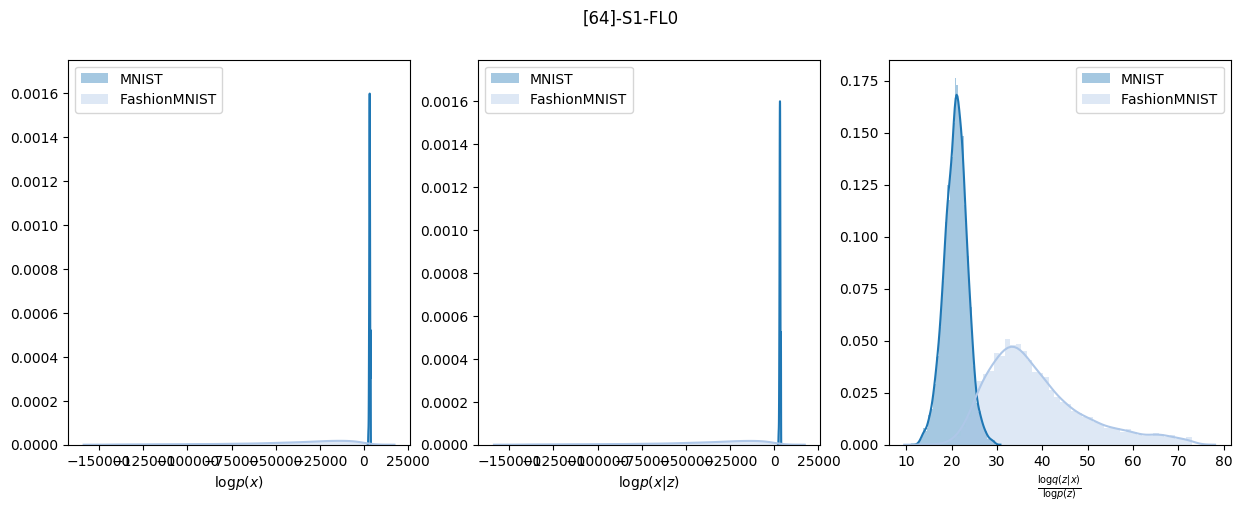

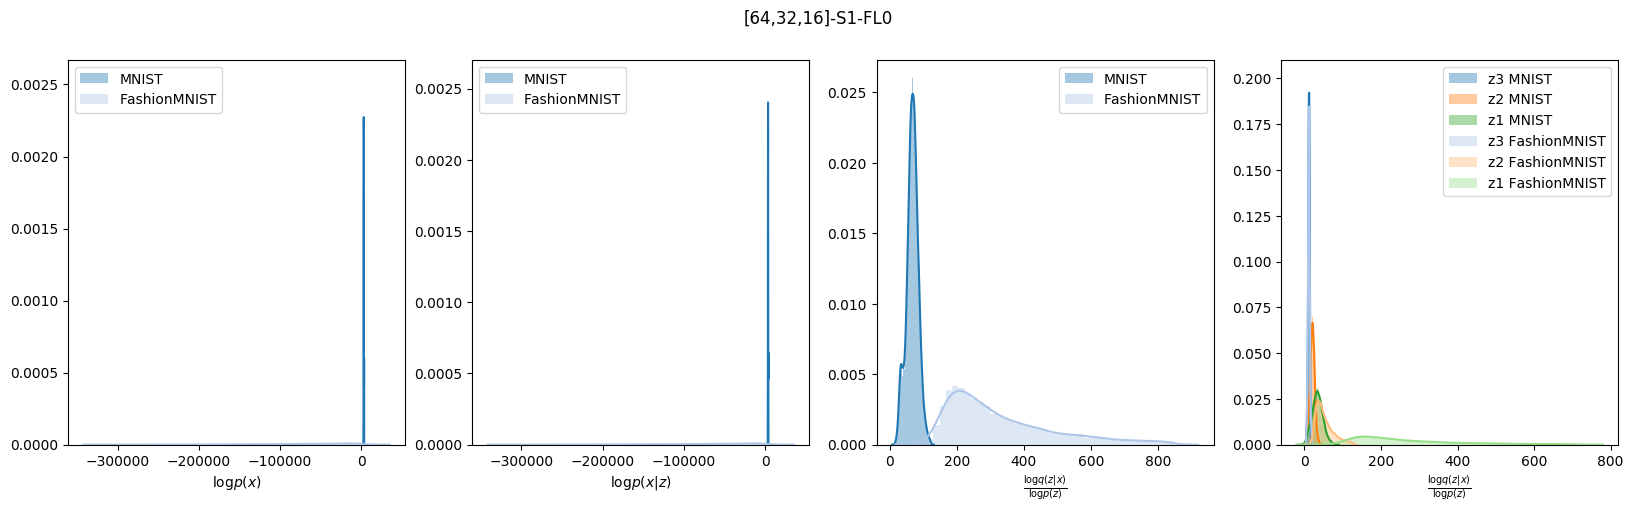

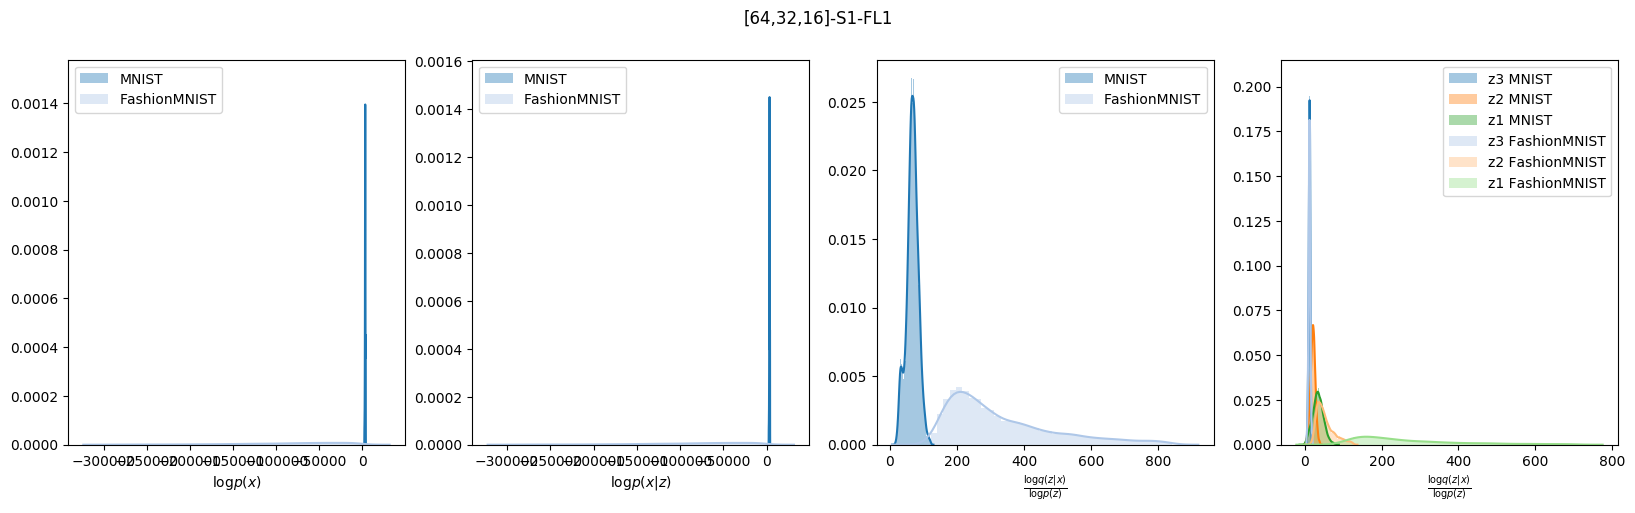

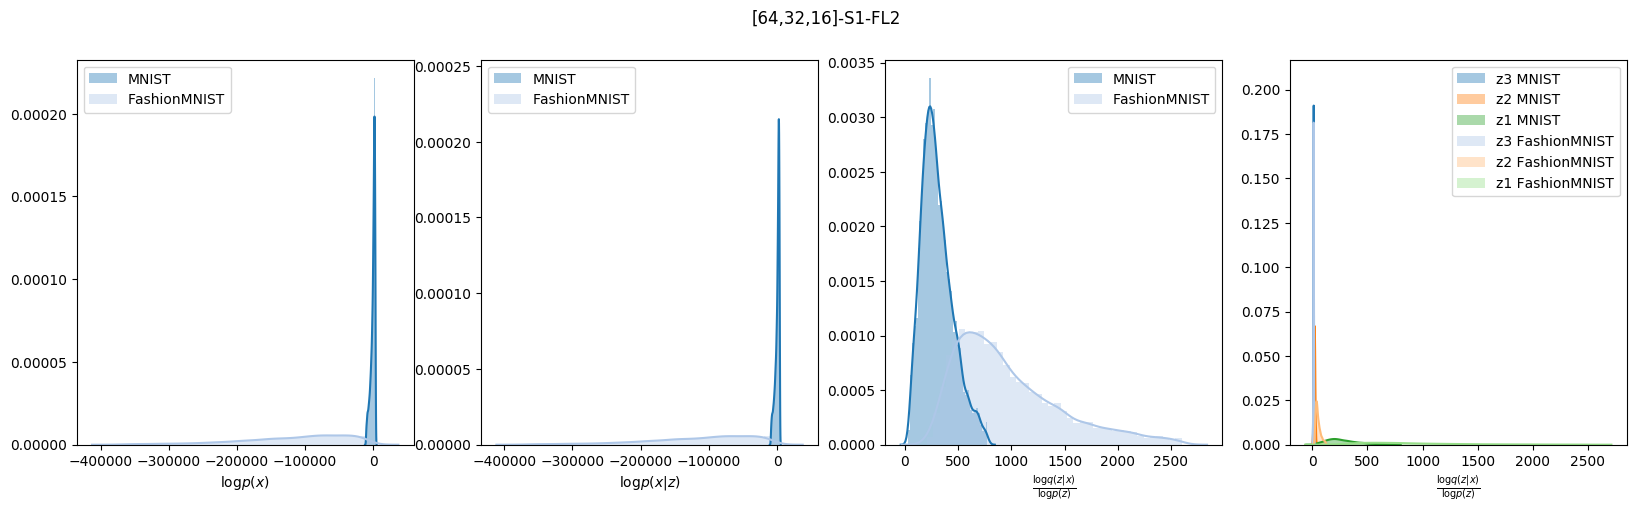

In [96]:
models = models_mnist
ids = run_ids_mnist
loaders_mnist = dict(MNIST=loader_mnist_test1,
                     FashionMNIST=loader_fashion_mnist_test1)
importance_samples = 1

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{ids[abbr]}-S{importance_samples}-FL{free_latents}'
        fig_suptitle = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_mnist, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_suptitle)
        fig.savefig(output_dir + f'/MNIST_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

### fashion_mnist

0 [64] small
0 [64]
0 [64,32,16]
1 [64,32,16]
2 [64,32,16]


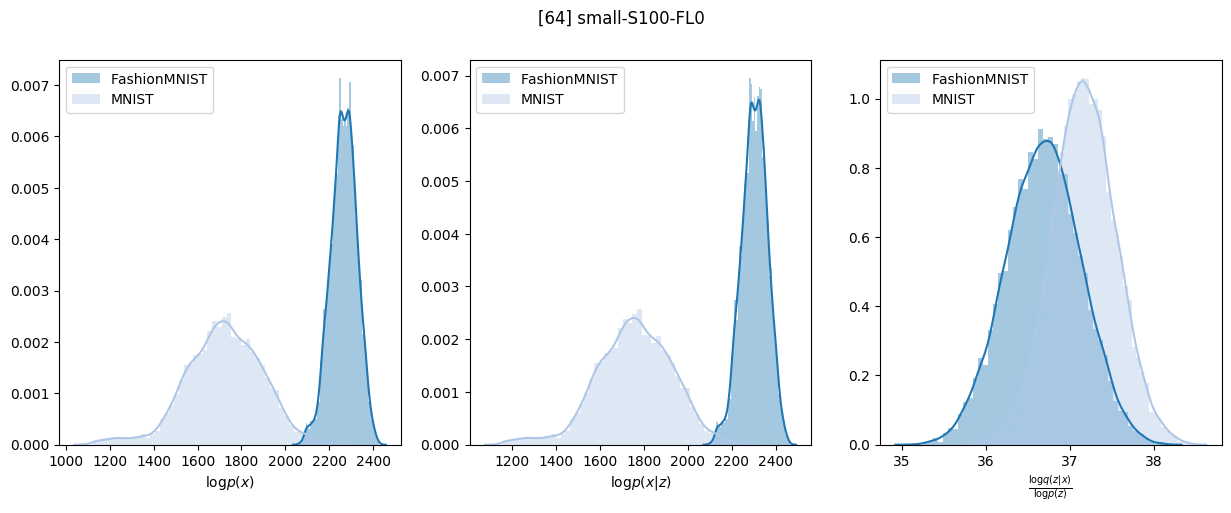

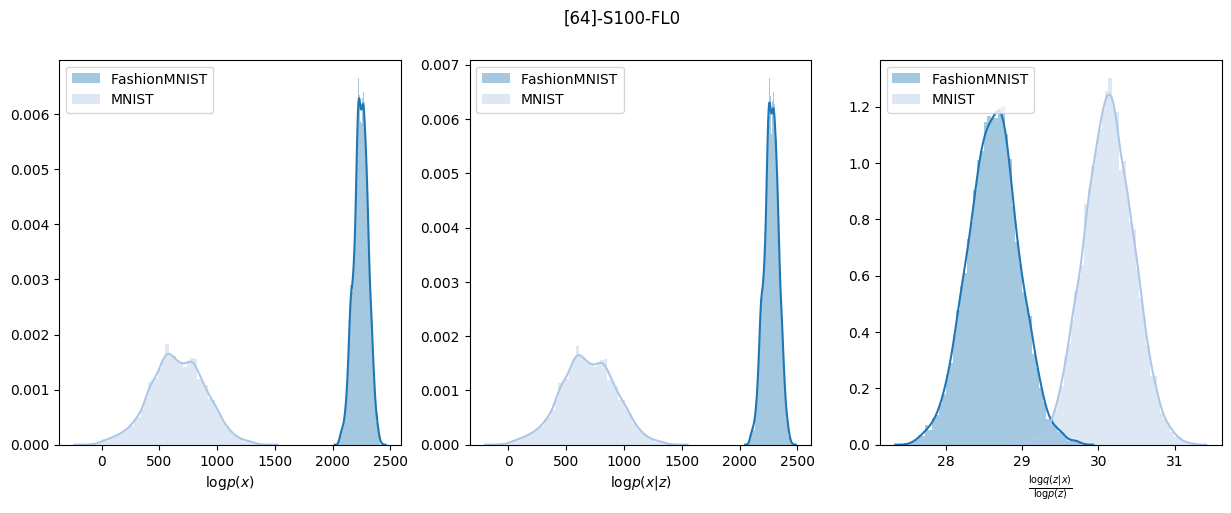

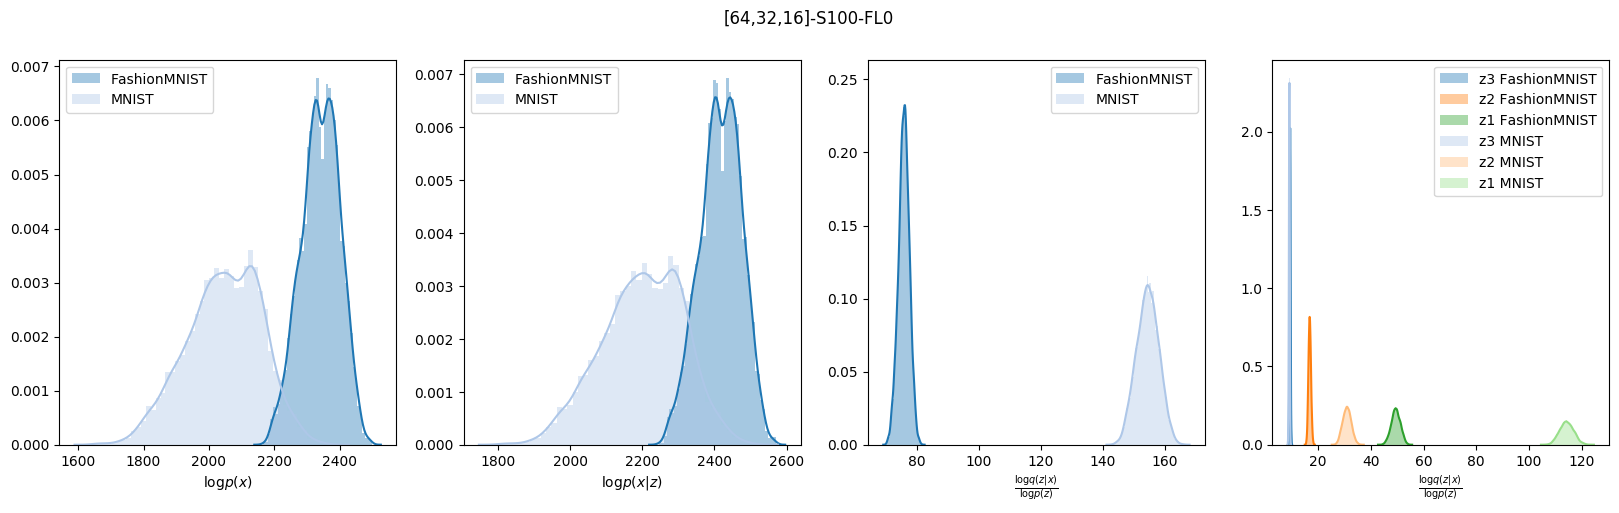

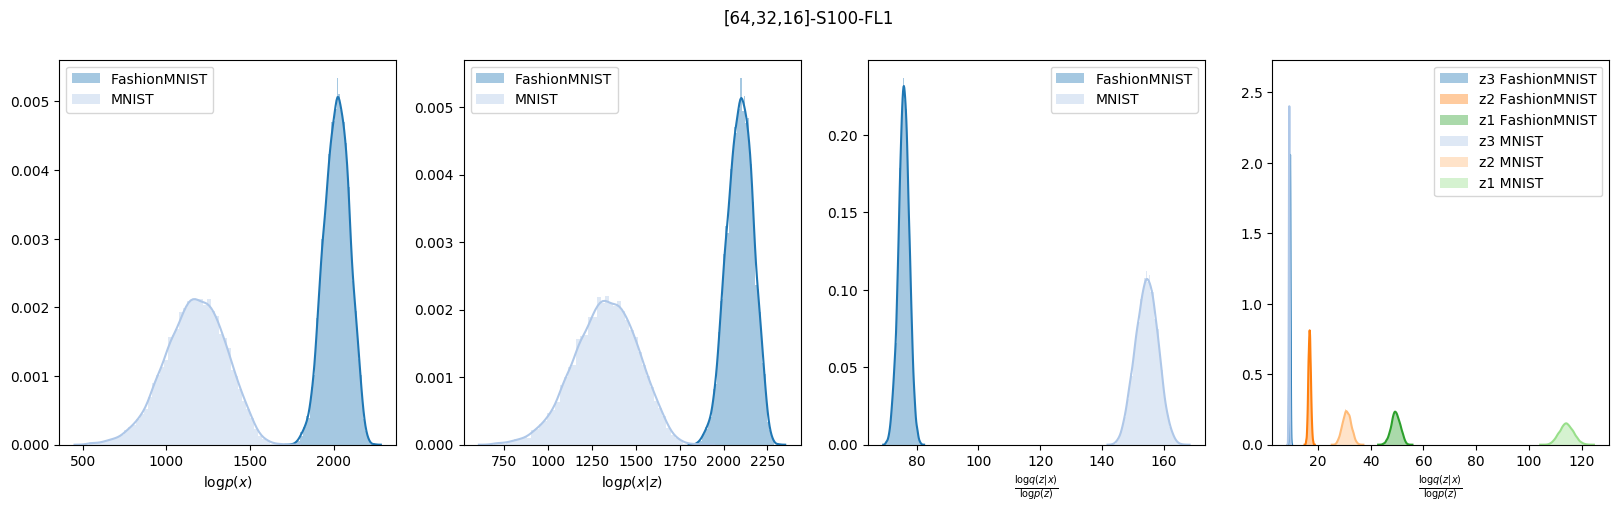

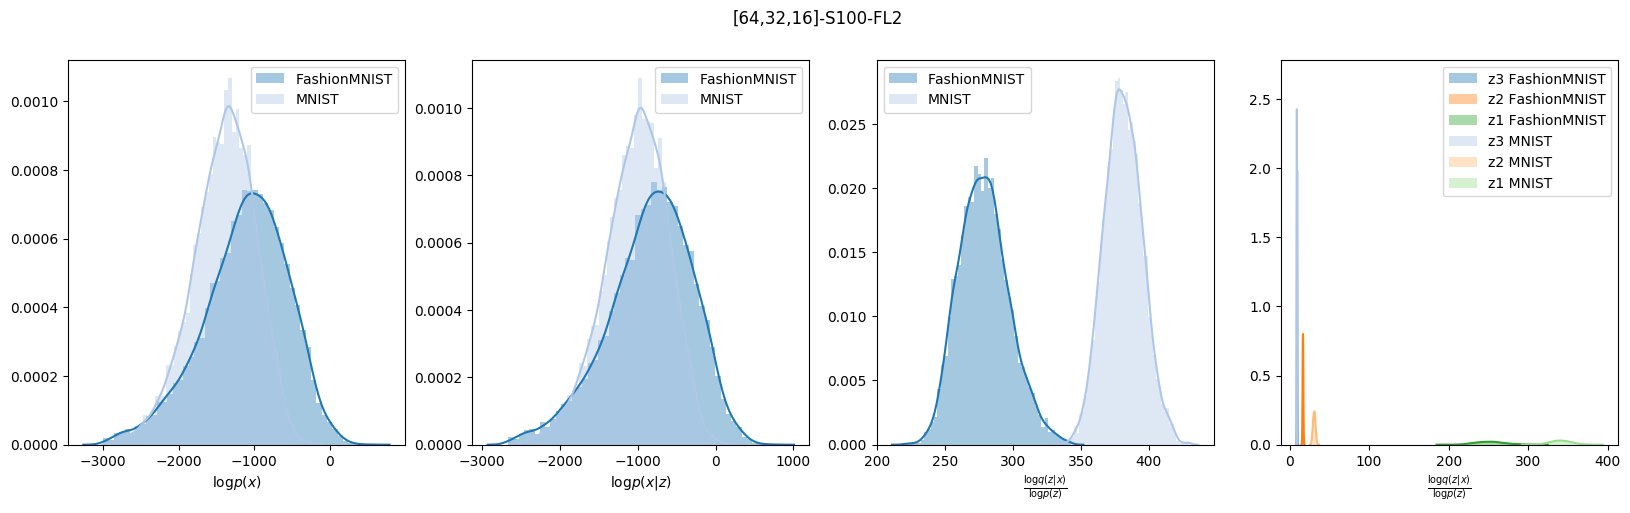

In [34]:
models = models_fashion_mnist
ids = run_ids_fashion_mnist
loaders_fashion_mnist = dict(FashionMNIST=loader_fashion_mnist_test1,
                             MNIST=loader_mnist_test1,)
importance_samples = 100

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{ids[abbr]}-S{importance_samples}-FL{free_latents}'
        fig_suptitle = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_fashion_mnist, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_suptitle)
        fig.savefig(output_dir + f'/FashionMNIST_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

0 [64]
0 [64,32]
1 [64,32]
0 [64,32,16]
1 [64,32,16]
2 [64,32,16]
0 [32,16,2,2]
1 [32,16,2,2]
2 [32,16,2,2]
3 [32,16,2,2]


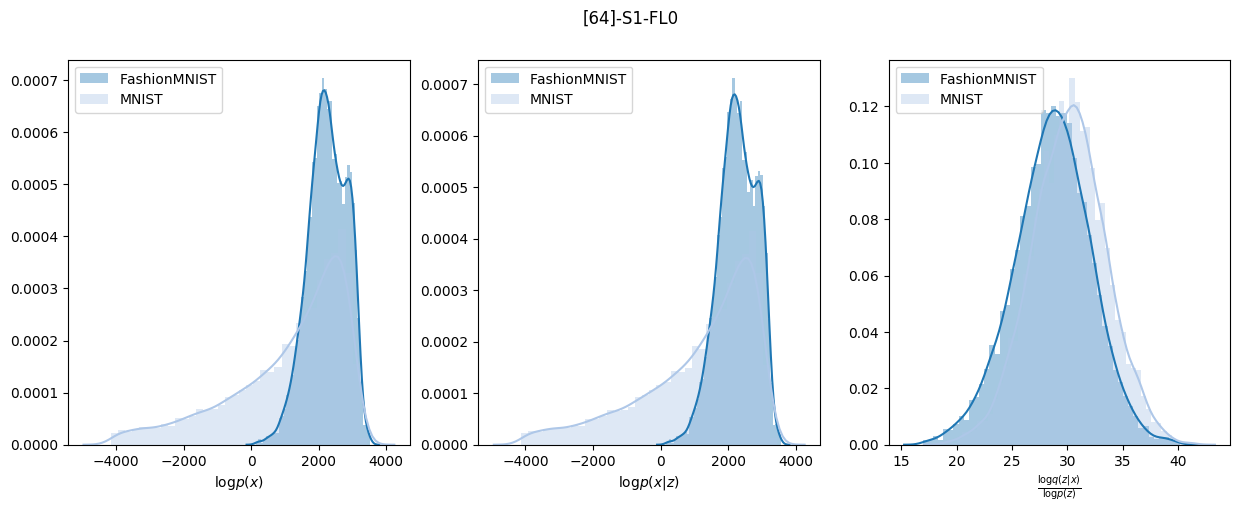

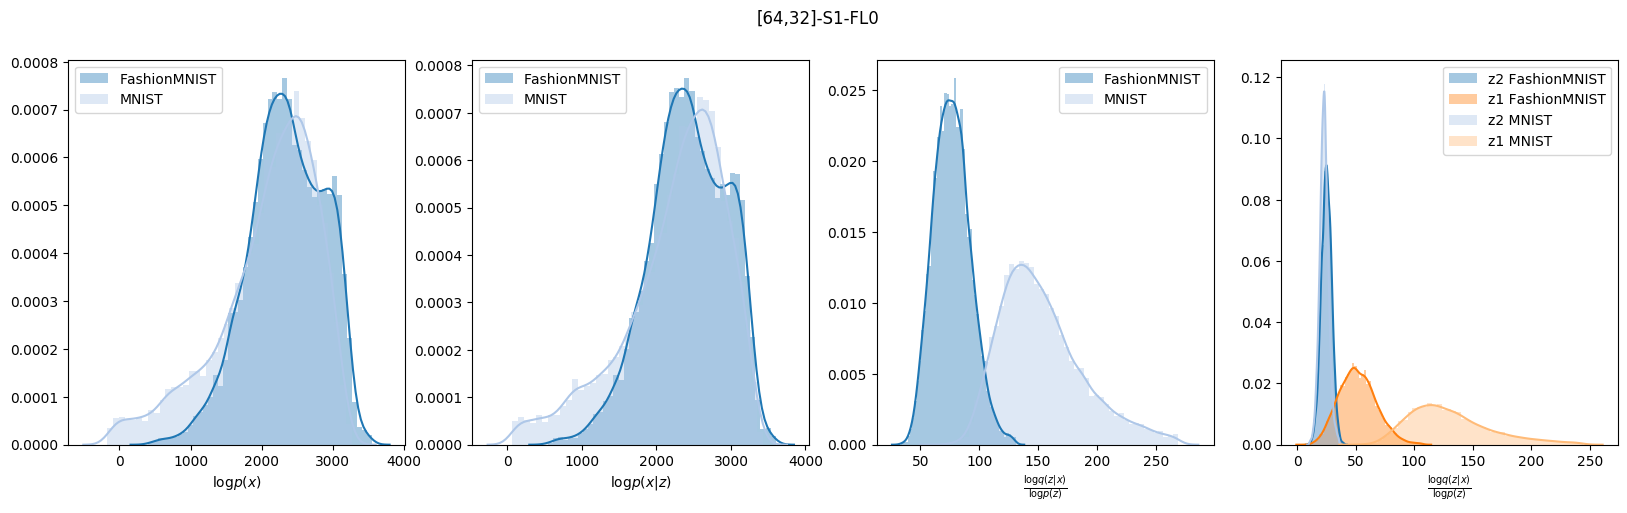

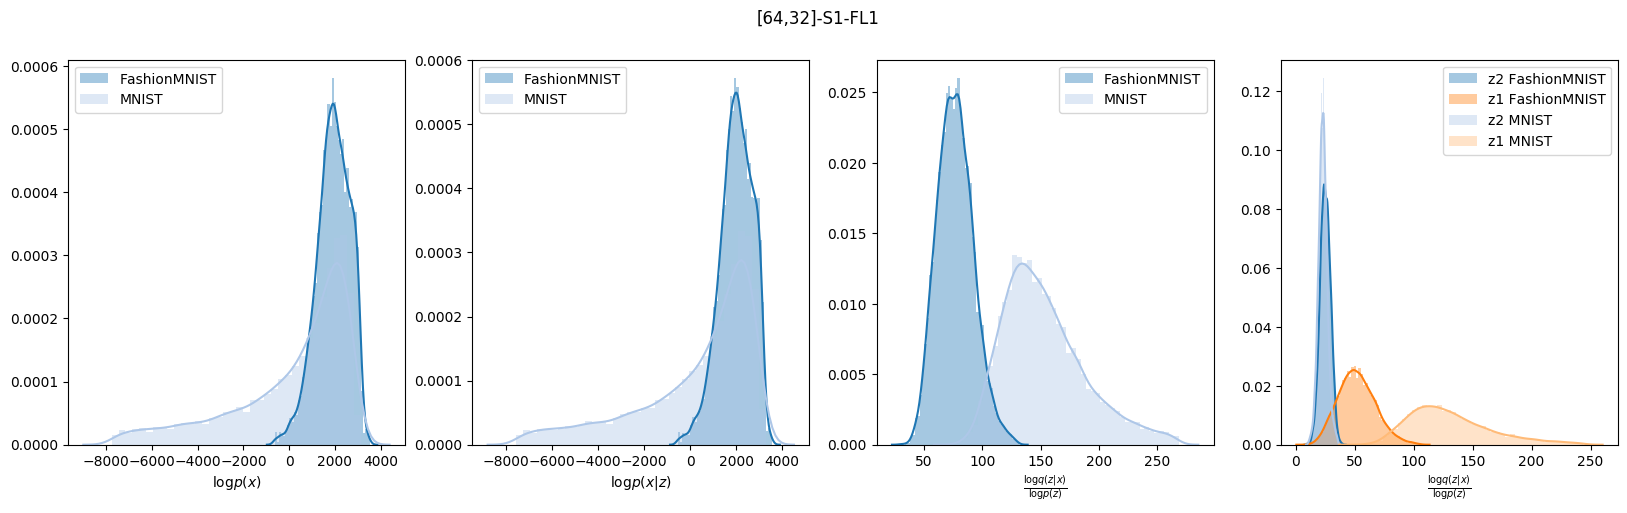

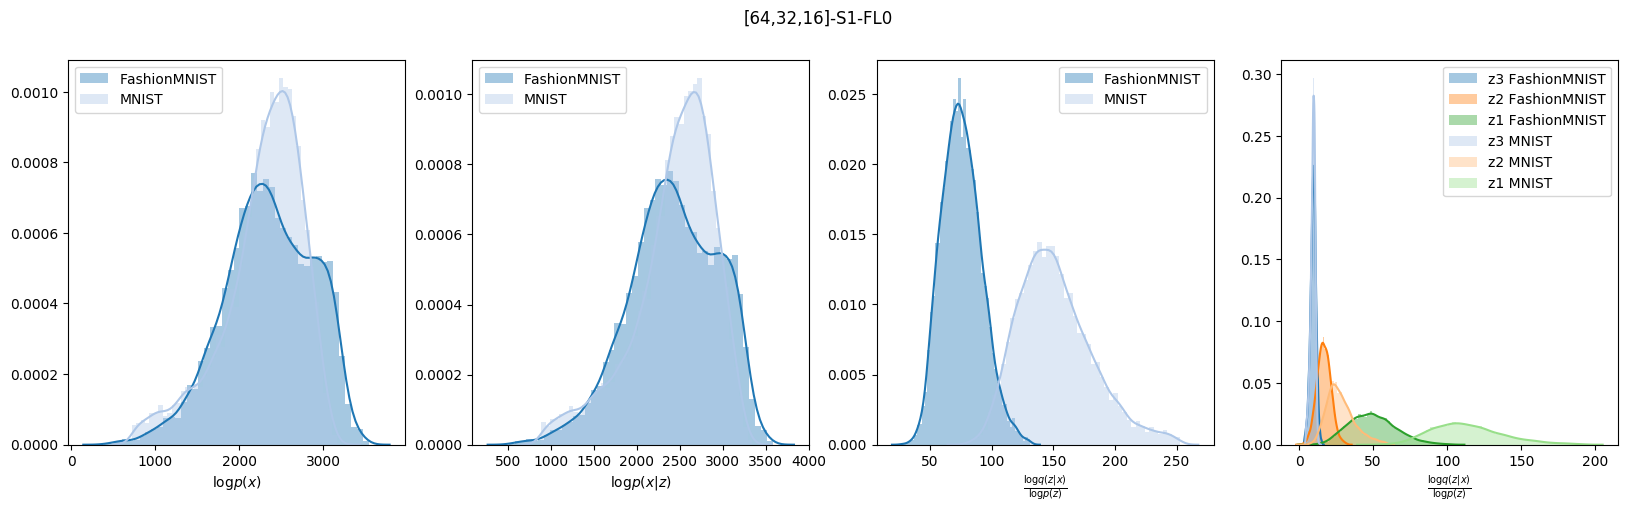

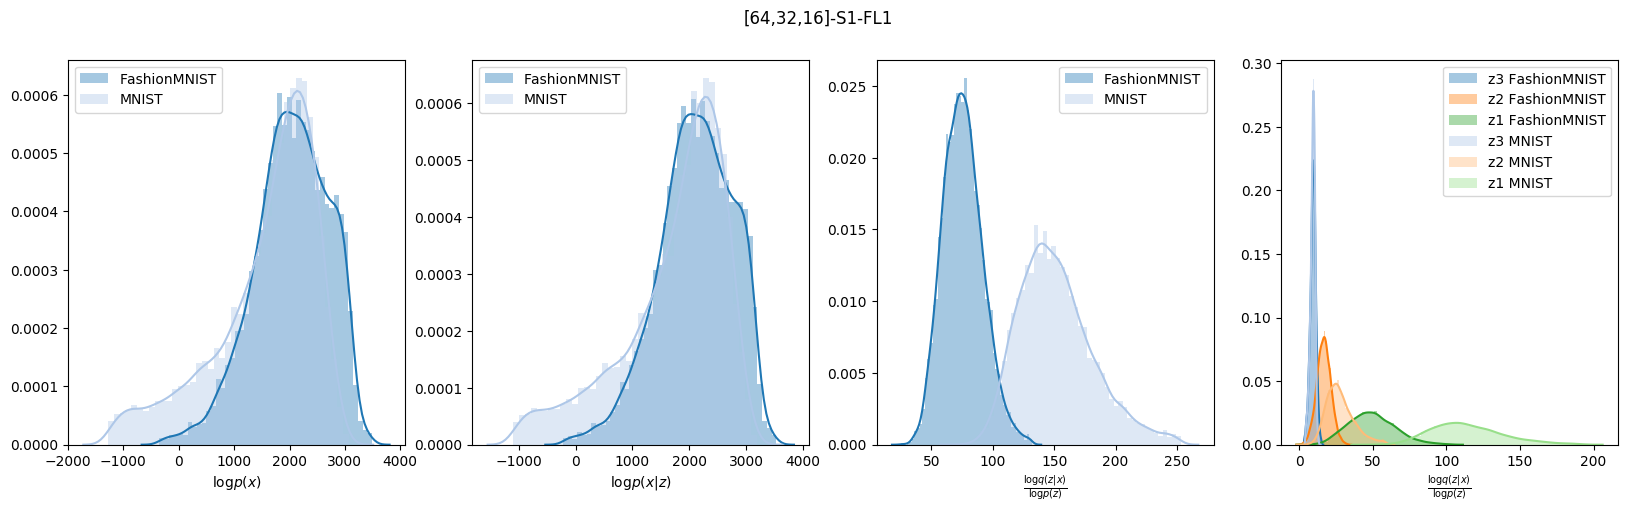

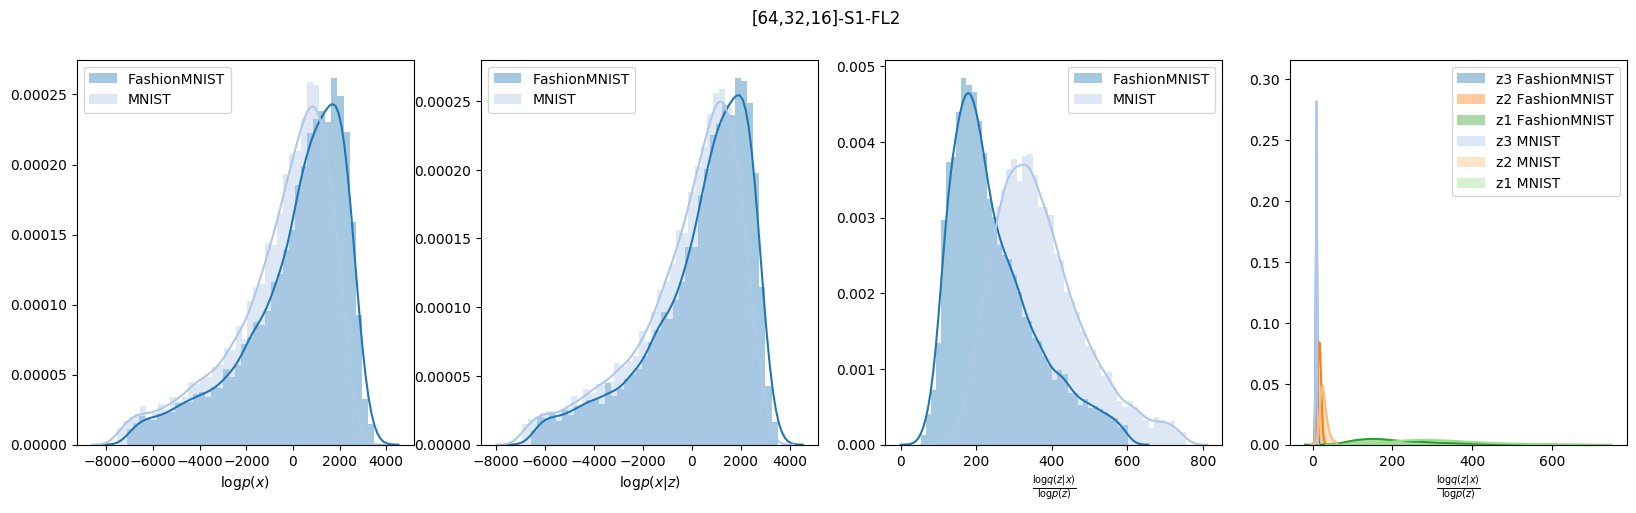

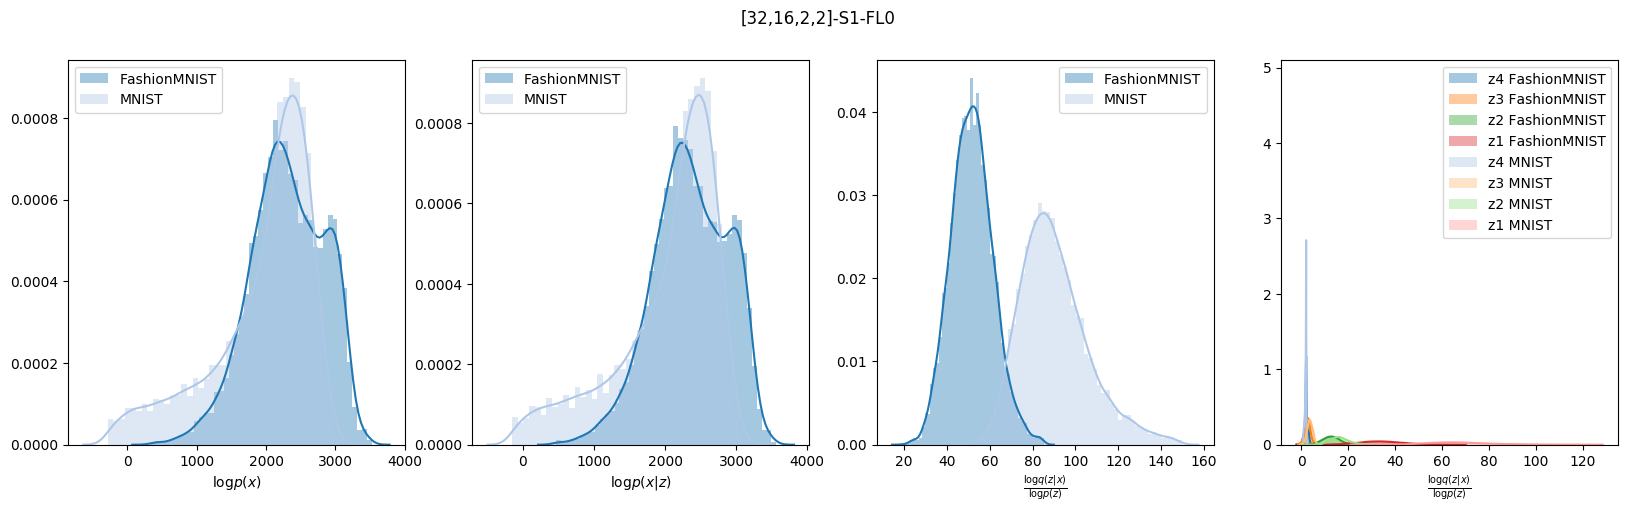

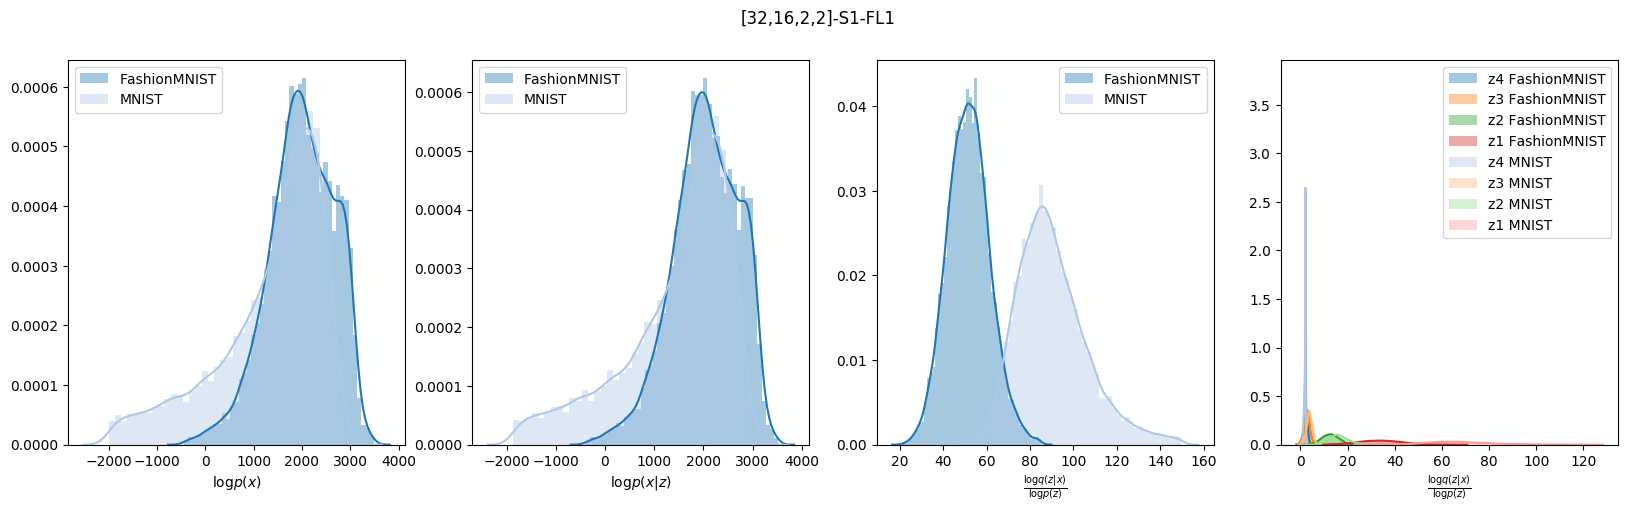

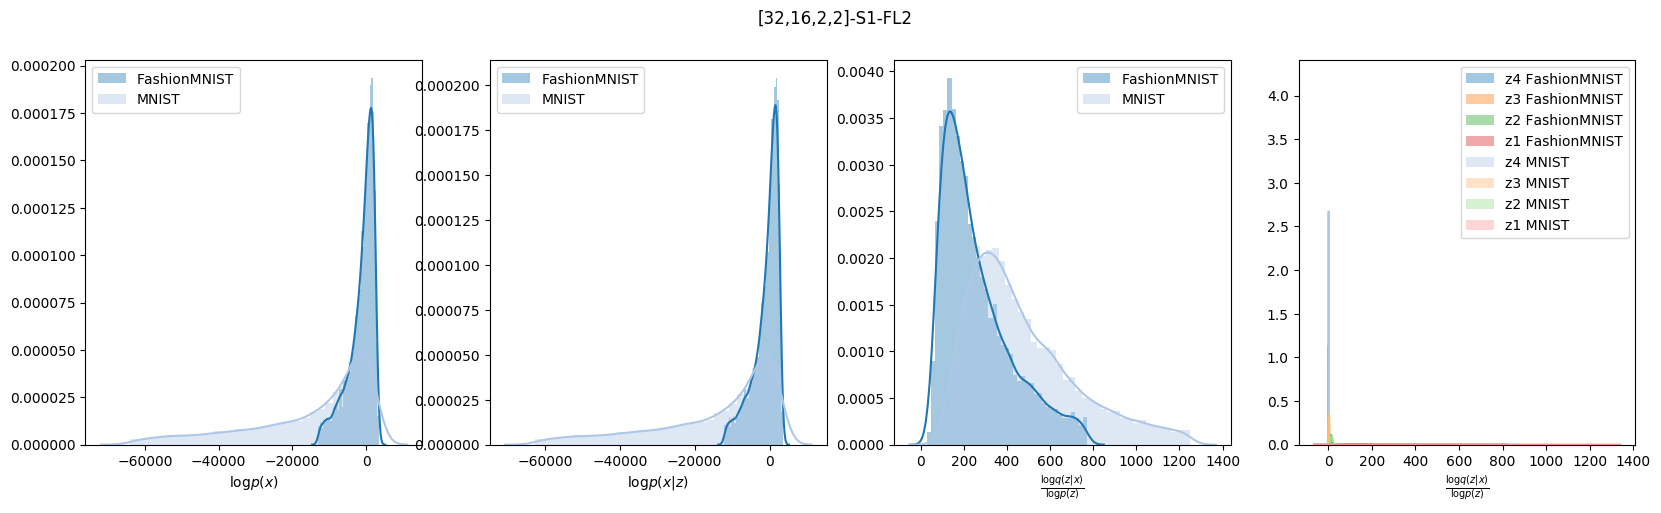

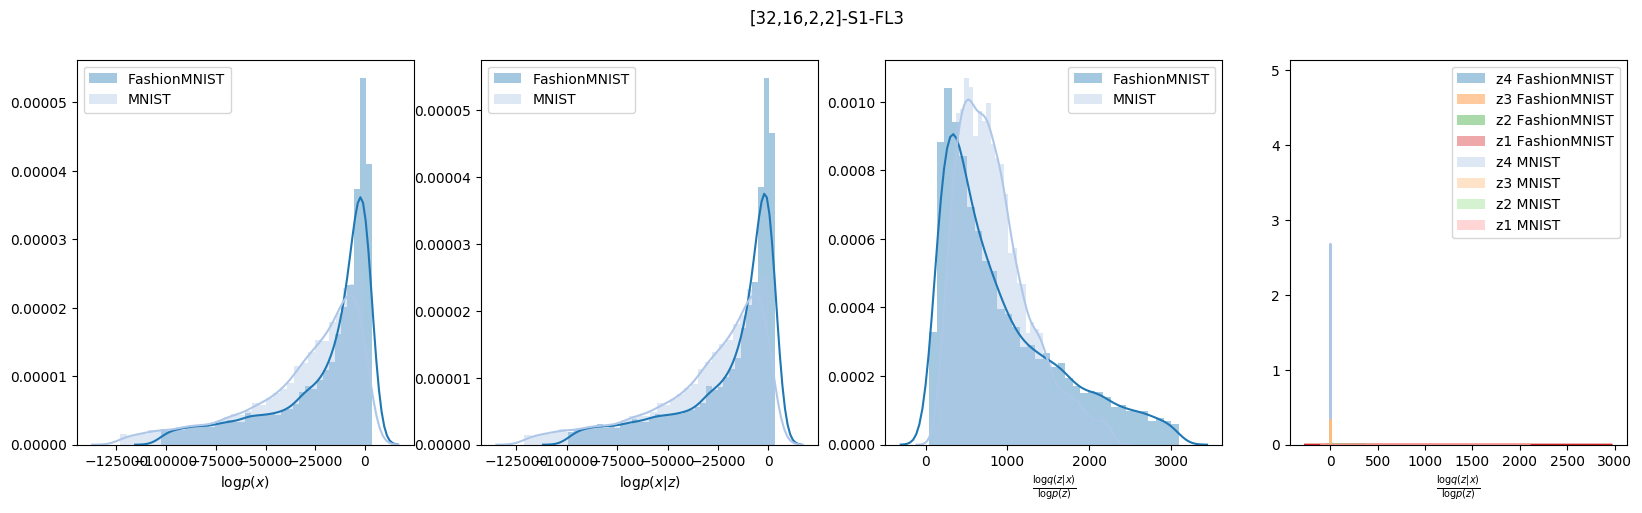

In [98]:
models = models_fashion_mnist
ids = run_ids_fashion_mnist
loaders_fashion_mnist = dict(FashionMNIST=loader_fashion_mnist_test1,
                             MNIST=loader_mnist_test1,)
importance_samples = 1

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{ids[abbr]}-S{importance_samples}-FL{free_latents}'
        fig_suptitle = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_fashion_mnist, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_suptitle)
        fig.savefig(output_dir + f'/FashionMNIST_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

## Animate generation during training

In [99]:
import matplotlib.pyplot as plt
import natsort

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [100]:
from IPython import embed
def get_substring_digit(s):
    return int(''.join([ss for ss in s if ss.isdigit()]))

def get_training_samples(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('model_samples.npy'):
            epoch = get_substring_digit(f)
            npys[epoch] = np.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

def get_training_latents(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('model_latents.pkl'):
            epoch = get_substring_digit(f)
            npys[epoch] = torch.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

In [101]:
run_id = '6867'
samples = get_training_samples(run_id)
latents = get_training_latents(run_id)

ValueError: invalid literal for int() with base 10: ''

In [ ]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)
scat = ax.scatter([], [])

def init():
    return (scat, )

def update(i):
    scat.set_offsets(npys[i])
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1, 1.5])
    ax.set_title(f'Epoch {i}')
    return (scat, )
    
    
epochs_sorted = natsort.natsorted(npys.keys())
anim = FuncAnimation(fig,
                     update,
                     frames=[*epochs_sorted[:1]*10, *epochs_sorted, *epochs_sorted[-1:]*10], 
                     init_func=init,
                     interval=150,
                     blit=True)

HTML(anim.to_html5_video())

In [ ]:
anim.save(f'training_samples_{run_id}.mp4', codec='h264')